# ***Tensorflow Architettura Adversarial (NO D.A.)  - A. Giacomini & D. Bernovschi***

## Setting Parametri Test (CROP e NO CROP) 

In [ ]:
#path_IMAGES = '/content/drive/MyDrive/CALCIO_CROP_BASE/'
path_IMAGES = '/content/drive/MyDrive/CALCIO_NOPRE/'

'''some useful parameters and variables'''
parte = 'CALCIO'
tipo = 'NO_CROP' #CROP, CROP_gray_ridge

#Ricordati di cambiare anche gli Hyper Parameters !!!!

## IMPORT

In [ ]:
'''IMPORTING LIBRARIES'''
'''Import packages &libraries for all the rest of the code'''
import sys
import subprocess
if 'google.colab' in sys.modules:
  subprocess.call("pip install -U progress".split()) 

import pandas as pd
import random
import os
import scipy.ndimage
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers, layers
from tensorflow.keras.layers import Activation, Input, Conv2D, ZeroPadding2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical 
from PIL import Image, ImageOps
from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, save_model, load_model
import matplotlib.pyplot as plt
import cv2
from random import randrange
print('Tensor Flow {}'.format(tf.__version__))
print('Keras {}'.format(tf.keras.__version__))

Tensor Flow 2.8.2
Keras 2.8.0


In [ ]:
'''vecchio costrutto'''
#random.seed( 40 )

'''nuovo costrutto'''
def fix_seeds(seed: int) -> None:
  """ Fix random seeds for numpy, tensorflow, random, etc.

  Parameters
  -----------
  seed : int.
  Random seed.
  """

  np.random.seed(seed) # numpy seed
  tf.random.set_seed(seed) # tensorflow seed
  random.seed(seed) # random seed
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)

fix_seeds(40)

## DRIVE 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'


Mounted at /content/drive


## Parametri Immagini 

In [ ]:
'''DEFINE VARIABLES AND PARAMETERS TO COLLECT THE INFORMATIONS FROM GOOGLE DRIVE'''
'''define a path for the collection of informations (CSV file) for the creation of the dataframe'''
os.chdir('/content/drive/MyDrive/ProgettoDL/') 

'''to have always the same sequence of randomized values (numbers)'''
random_state = 3  

'''some useful parameters and variables'''
augment = True
metaclassi = False
cnn = "vgg16" 

'''series of production & quality classes of the wood rifle butt'''
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']          
serie = [2,4,8,10,6,9,3,11,12,13,14,15,7] 
cod_componente = [ 2,  4,  8, 10,  6,  9,  3, 11, 12, 13, 14, 15,  7]

'''size of the images & their paths (location) '''
immg_rows = 270 
immg_cols = 470
immgs = '{}_{}'.format(parte,tipo)
path_imgs = os.path.join(path_drive+'{}'.format(immgs))

'''CSV loading (reading annotations/attributes/informations)'''
csv = pd.read_csv(('/content/drive/MyDrive/ProgettoDL/20201102_ExportDB.txt'), sep=";")

## SPLIT DATA

In [ ]:
'''CUSTOM SPLIT DATA INTO TRAIN/TEST/VALIDATION SETS'''
"""
NOTE
- VERSIONE CON NUMERI PRESI DIRETTAMENTE DAL BILANCIAMENTO CALCOLATO RISPETTO IL TOTALE DI 2120 (che ci sono in questo progetto), PER RENDERLO DINAMICO CALCOLARE PESI IN MODO AUTOMATICO (STUDIA ALTERNATIVA)
- UNICO PROBLEMA È CHE A VOLTE IMMAGINI CON STESSO ID HANNO IN REALTÀ DIVERSA CLASSE DI QUALITÀ, QUINDI I DATASET NON SONO PERFETTAMENTE BILANCIATI MA VARIANO LEGGERMENTE,
(perchè lo stesso ID deve stare in stesso set anche se i lati del calcio del fucile possono avere qualità differente)
"""

'''split method'''
def split_data(dataframe_result, val_size, test_size, random_state):
  #n_ immagini per ciascuna classe di qualità
  classes_count = dataframe_result.groupby(['class']).size() 

  unique_result, counts = np.unique(dataframe_result['ID'], return_counts=True)   #conto quanti ID univoci esistono nel dataset e li raccolgo tutti in vettore

  '''randomizing the order of the IDs, (to change the sequence change the random_state)'''
  #id_perm = unique_result.iloc[np.random.permutation(unique_result.index)].reset_index(drop=True)
  id_perm = np.random.RandomState(random_state).permutation(unique_result)
  #print('ID Perm : {}'.format(id_perm))
               
  '''define finals sub-sets of data'''
  column_names = ['ID','series','filename','class']
  x_train = pd.DataFrame(columns = column_names)

  x_test = pd.DataFrame(columns = column_names)

  x_val = pd.DataFrame(columns = column_names)

  '''define variables to count elements inside the sub-sets'''
  conta, conta0, conta1, conta2, conta3, conta4, conta5, conta6, conta7, conta8, conta9 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
  class_ = 0


  '''performing cycles to divide the images into the 3 sub-sets'''
  for i in id_perm:
     result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
      #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
     if result_ID[result_ID.columns[0]].count() == 2:
       row_1=result_ID.iloc[0]
       class_ = int(row_1['class'])
       row_2=result_ID.iloc[1]
       class2_ = int(row_2['class'])
       conta = 2
       #print("ID doppio")
     else:
       row_1=result_ID.iloc[0]
       class_ = int(row_1['class'])
       conta = 1
       #print("ID singolo")

     if class_ == 0 and conta0 < int((classes_count[0]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 < int((classes_count[1]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 < int((classes_count[2]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 < int((classes_count[3]/100)*60) :
        if conta == 2 :
          x_train=x_train.append(row_1, ignore_index=True) 
          x_train=x_train.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_train=x_train.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 < int((classes_count[4]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 < int((classes_count[5]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 < int((classes_count[6]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 < int((classes_count[7]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 < int((classes_count[8]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 < int((classes_count[9]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1
     elif class_ == 0 and conta0 >= int((classes_count[0]/100)*60) and conta0 < int((classes_count[0]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 >= int((classes_count[1]/100)*60) and conta1 < int((classes_count[1]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 >= int((classes_count[2]/100)*60) and conta2 < int((classes_count[2]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 >= int((classes_count[3]/100)*60) and conta3 < int((classes_count[3]/100)*80) :
        if conta == 2 :
          x_val=x_val.append(row_1, ignore_index=True) 
          x_val=x_val.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_val=x_val.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 >= int((classes_count[4]/100)*60) and conta4 < int((classes_count[4]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 >= int((classes_count[5]/100)*60) and conta5 < int((classes_count[5]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 >= int((classes_count[6]/100)*60) and conta6 < int((classes_count[6]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 >= int((classes_count[7]/100)*60) and conta7 < int((classes_count[7]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 >= int((classes_count[8]/100)*60) and conta8 < int((classes_count[8]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 >= int((classes_count[9]/100)*60) and conta9 < int((classes_count[9]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1
     elif class_ == 0 and conta0 >= int((classes_count[0]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 >= int((classes_count[1]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 >= int((classes_count[2]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 >= int((classes_count[3]/100)*80) :
        if conta == 2 :
          x_test=x_test.append(row_1, ignore_index=True) 
          x_test=x_test.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_test=x_test.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 >= int((classes_count[4]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 >= int((classes_count[5]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 >= int((classes_count[6]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 >= int((classes_count[7]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 >= int((classes_count[8]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 >= int((classes_count[9]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1

    
  return x_train, x_test, x_val


## DATA GENERATION 

In [ ]:
import os
import pandas as pd
import numpy as np
import keras
import cv2
from google.colab.patches import cv2_imshow
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight

class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size = (270, 470),
                 shuffle = True):
      
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_CLASSE_CALCIO = df[y_col['CLASSE']].nunique()
        self.n_SERIE_CALCIO = df[y_col['GEOMETRIA']].nunique()

        self.class_augmented = {0:0 , 1: 0, 2:0 , 3: 0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
        self.class_augmented_base = {0:0 , 1: 0, 2:0 , 3: 0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

        self.check_index_0 = 0  #aggiunto per sistemare la cattura di tutte le immagini dal dataset
        self.number_epochs = 0  #per contare le epoche e fare prima addestramento con immagini normali e poi con quelle trasformate, dopo diciamo 10 epoche
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)
        'reset check index 0 and increment number of epochs for controls'
        self.check_index_0 = 0
        self.number_epochs = self.number_epochs + 1 

        #print('\n Self Augmented : {}  - number of epochs : {} \n'.format(self.class_augmented, self.number_epochs))
    
    def __get_input(self, path, target_size):
      try:
        image = tf.keras.preprocessing.image.load_img(path_IMAGES+path, color_mode="rgb" , target_size=(target_size[0],target_size[1]))
      except Exception:
        print('\n{}_not found'.format(path))
      
      image_arr = tf.keras.preprocessing.image.img_to_array(image)
      image_arr = tf.keras.applications.vgg16.preprocess_input(image_arr, data_format="channels_first")               
      #image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()  #c'è già il target_size sopra, quindi non serve

      return image_arr
    
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)

    def __get_output2(self, label, num_series):
        return tf.keras.utils.to_categorical(label, num_classes=num_series)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.X_col['PATH_IMG']]  
        CLASSE_batch = batches[self.y_col['CLASSE']]
        SERIE_batch = batches[self.y_col['GEOMETRIA']]

        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])
        y_batch_ = np.asarray([self.__get_output(y, self.n_CLASSE_CALCIO) for y in CLASSE_batch])
        z_batch_ = np.asarray([self.__get_output2(z, self.n_SERIE_CALCIO) for z in SERIE_batch])

        y_tot = np.column_stack((y_batch_,z_batch_))
 
        '''
        print("shape y_batch : {}".format(np.shape(y_batch_)))
        print("shape y_batch_head : {}".format(y_batch_[1:5]))

        print("shape z_batch : {}".format(np.shape(z_batch_)))
        print("shape z_batch_head : {}".format(z_batch_[1:5]))

        print("shape y_tot : {}".format(np.shape(y_tot)))
        print("shape y_tot_head : {}".format(y_tot[1:5]))
        '''
        
        return X_batch, {'class_output': y_tot, 'series_output': z_batch_}
  
        

    def __getitem__(self, index):

        if index == 0 and self.check_index_0 == 0:
          self.check_index_0 =+1
          batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        elif index == 0 and self.check_index_0 == 1:
          self.check_index_0 =+1  #così il secondo 0 lo uso come 9
          batches = self.df[-self.batch_size:]
        else:
          batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__get_data(batches)

        return X, y



    def __len__(self):
        return int(self.n) // self.batch_size



## PREPROCESSING IMAGES & DATA FRAME CREATION

In [ ]:
'''verify that same IDs are in the same sub-sets'''

'''method for univoque sets'''
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) >= 1 # boolean (true if there is at least 1 patient in both groups)
        
    return leakage

In [ ]:
'''PREPROCESSING PHASE OF THE DATAFRAME (CREATIONS OF THE SUBSETS TRAIN/VALIDATION/TEST, CALCULATE WEIGHTS OF ELEMENTS OF THE SUBSETS, VERIFY THAT SAME IDs ARE IN THE SAME SUBSET)'''
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from pandas.compat._optional import import_optional_dependency


os.chdir('/content/drive/MyDrive/ProgettoDL')
path = os.getcwd()


'''reading inforamtions from the CSV'''
col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")


col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")


'''rename the dataframe columns'''
dataframe_sx.columns = ['ID','series', 'filename', 'class']
dataframe_dx.columns = ['ID','series', 'filename', 'class']

frames = [dataframe_sx, dataframe_dx] 
result = pd.concat(frames) #concatenate the two dataframes

print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("DATAFRAME COMPLETO INIZIALE")
print("result")
print(result)


'''mapping the values used for the classification into integer values'''
#version with 10 classes
result["class"] = result["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result["series"] = result["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)}) 


'''identification of NULL values that would bring the execution on failing and eliminate those values'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Number of Null values in column 'quality_classes' : "+format(result['class'].isnull().sum()))
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
#print(result.loc[result['class'] == '0'])
print("mostro quegli elementi che hanno valore nullo")
print(result[result['class'].isnull()])
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")

'''Remove Null elements to avoid failures during executions (data in not useful!)'''
print("Rimuovo gli elementi nulli e verifico stampando nuovamente i valori nulli:")
result['class'] = pd.to_numeric(result['class'], errors='coerce')
result = result.dropna(subset=['class'])    #rimuovo le righe con elementi nulli

print("elementi nulli rimasti: "+format(result['class'].isnull().sum()))     #stampo per verifica se ci sono elementi nulli


'''verify if images exist in the Google Drive folder, when not present it is eliminated from the dataset aswell'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("elimino i file che non sono presenti in Google Drive anche se ci sono nel CSV")
print('CHECK FILE NON PRESENTI NELLA CARTELLA')

#--------TORNA QUI ---------
os.chdir(path_IMAGES)

i = 0; 
for index, row in result.iterrows():
    filename = row['filename']
    if os.path.exists(path_IMAGES+filename) == False:
      
      print('File Non Esiste !!!')
    if(os.path.exists(filename) == False):
      result = result.drop(result[(result['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))
      i = i + 1             
print('File Eliminati : {} '.format(i))

print('CHECK FILE CON NaN')
print(result[result['class'].isnull()])
print(result[result['series'].isnull()])
print(result[result['filename'].isnull()])
print(result[result['ID'].isnull()])
result = result[result['class'].notna()]
result = result[result['series'].notna()]
result = result[result['filename'].notna()]
result = result[result['ID'].notna()]

'''performing the splitting of the dataframe into sub-sets'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("SPLIT DATA")
train_balance_df, test_balance_df, val_balance_df  = split_data(result, 0.2, 0.2, 3)  #CUSTOM SPLIT CON ID IN STESSO SET DI DATI
#train_mask, test_mask, validation_mask  = split_data(result2, 0.2, 0.2, 3)           #split per test con immagini con maschere

print("train_balance_df")
print(train_balance_df)
print("test_balance_df")
print(test_balance_df)
print("val_balance_df")
print(val_balance_df)

'''verify distibution of classes in the sub-sets and calculate weights of the classes in each sub-set'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
vals, counts = np.unique(train_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Train")
print(len(train_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts[i]))

vals2, counts2 = np.unique(val_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Validation")
print(len(val_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts2[i]))

vals3, counts3 = np.unique(test_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Test")
print(len(test_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts3[i]))    


class_weights_train = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(train_balance_df['class']),y = train_balance_df['class'])
weight_train = {i : round(class_weights_train[i], 2) for i in range(len(classi))} 
print('Weight train_balance_df')
print(weight_train)

class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(val_balance_df['class']),y = val_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weight val_balance_df')
print(weight)

class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(test_balance_df['class']),y = test_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weight test_balance_df')
print(weight)

#--------verifico che stessi ID siano in stesso set--------
print("test case 1 - train VS validation")
print(f"Stessi ID in set usati?: {check_for_leakage(train_balance_df, val_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 2 - train VS test")
print(f"Stessi ID in set usati ?: {check_for_leakage(train_balance_df, test_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 3 - validation VS test")
print(f"Stessi ID in set usati?: {check_for_leakage(val_balance_df, test_balance_df, 'ID')}")


------------------------------------------------------------------------------------------------------------------------------------------------------------
DATAFRAME COMPLETO INIZIALE
result
        ID  series            filename class
0        3       2  20201 319 5323.png    3+
1        4       2  20201 3110125 .png    3+
2        5       2  20201 31101327.png    3+
3        6       2  20201 3110161 .png    3+
4        7       2  20201 3110177 .png    3+
...    ...     ...                 ...   ...
1059  2023       7  20201031090549.png    3+
1060  2024       7  20201031090855.png    3+
1061  2025       7  20201031091127.png    3+
1062  2026       7  20201031091720.png    3+
1063  2027       7  20201031091941.png    3+

[2128 rows x 4 columns]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Null values in column 'quality_classes' : 2
- - - - - - - - - - - - - - - - 

In [ ]:
'''Verifica Classi Qualità per ogni Serie'''
print("Verifica Classi Qualità per ogni Serie")
result_x_ = result.groupby(['series','class']).size()
result_class = result.groupby(['class']).size()
print(result_class)
result_series = result.groupby(['series']).size()
print(result_series)

print('SOMMA IMG : {}'.format(result_class[0]+result_class[1]+result_class[2]+result_class[3]+result_class[4]+result_class[5]+result_class[6]+result_class[7]+result_class[8]+result_class[9]))

Verifica Classi Qualità per ogni Serie
class
0.0    165
1.0    148
2.0    212
3.0    177
4.0    179
5.0    307
6.0    343
7.0    208
8.0    275
9.0    106
dtype: int64
series
0     120
1     224
2     200
3     226
4     430
5     120
6     168
7     218
8      28
9      76
10     54
11     74
12    182
dtype: int64
SOMMA IMG : 2120


##Weighted Categorical Cross-Entrophy

In [ ]:
from keras import backend as K
class weighted_categorical_crossentropy(object):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        loss = weighted_categorical_crossentropy(weights).loss
        model.compile(loss=loss,optimizer='adam')
    """
    
    def __init__(self,weights):
        self.weights = K.variable(weights)
        
    def loss(self,y_true, y_pred):
        #print('stop')
        
        # scale preds so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred)
        # clip
        y_pred = K.clip(y_pred, K.epsilon(), 1)
        # calc
        
        loss = y_true*K.log(y_pred)*self.weights
        loss =-K.sum(loss,-1)
        return loss

## NETWORK 

58900480/58889256 [==============================] - 0s 0us/step
Model: "quality_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 270, 470, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 270, 470, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 270, 470, 64  36928       ['block1_conv1[0][0]']           
                

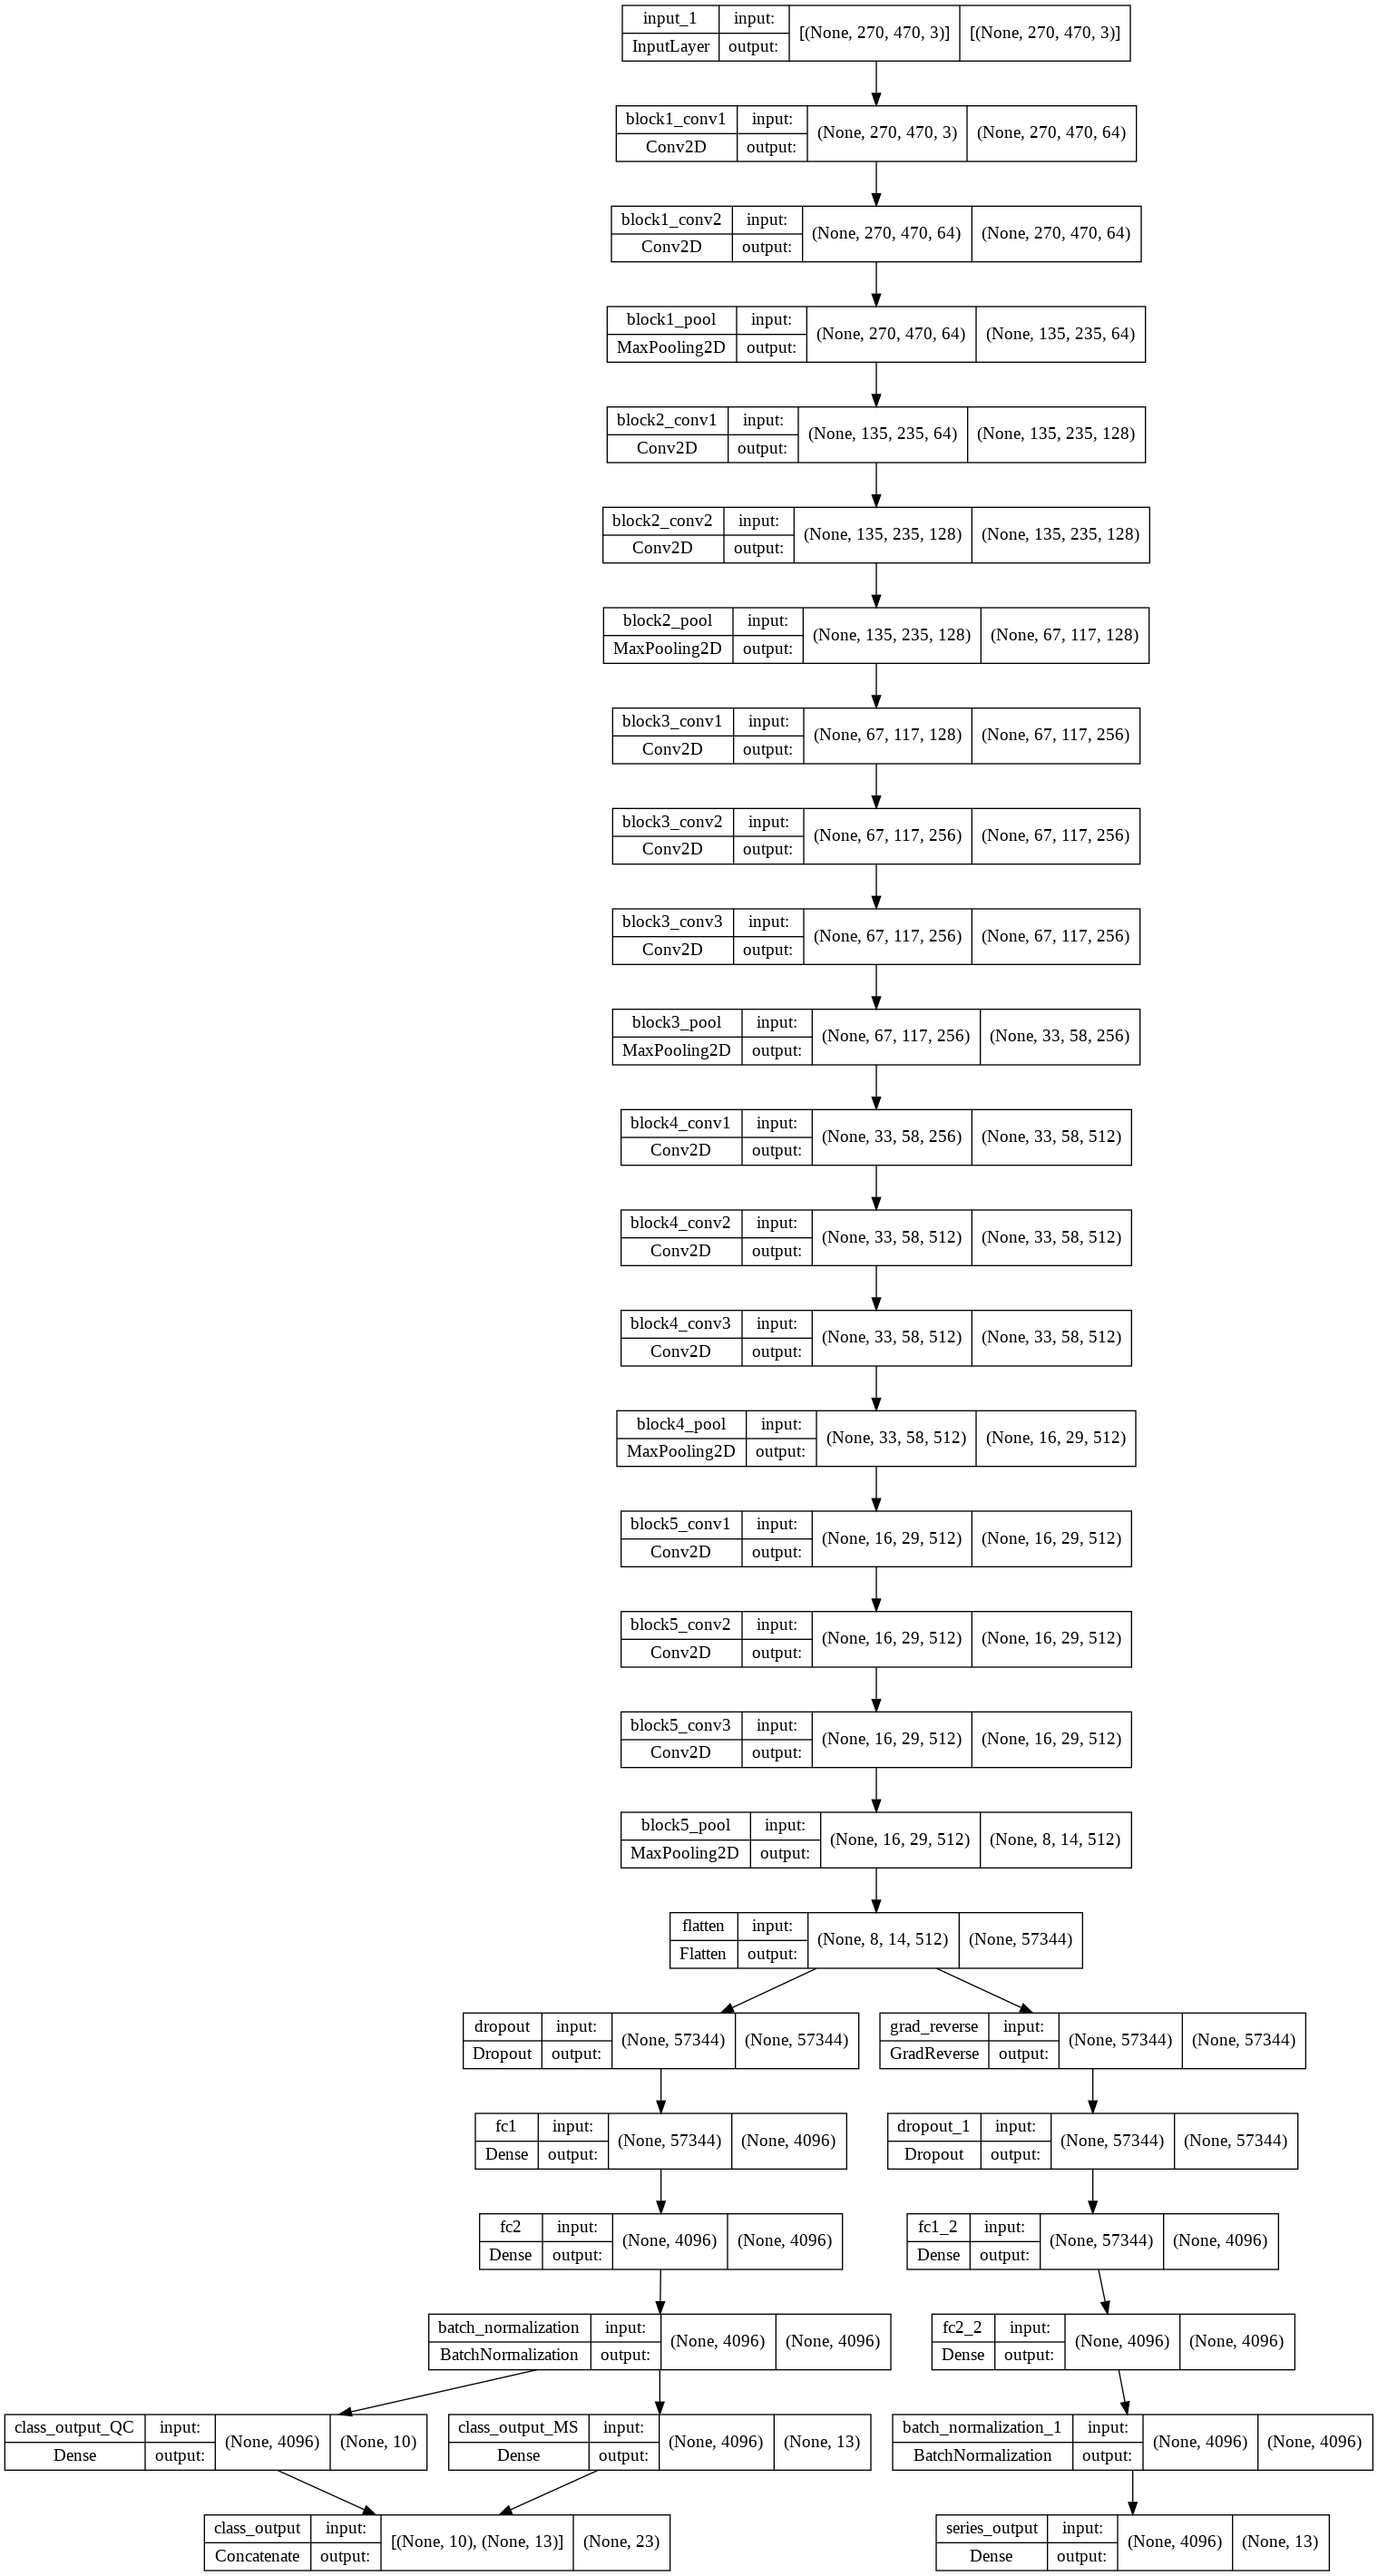

In [ ]:
'''NETWORK DEFINITION'''


'''build the top model'''
model = Sequential()

vgg16_conv = VGG16(include_top=False, weights='imagenet', input_shape=(immg_rows, immg_cols, 3))      #pre allenata con immagini di imagenet, e quindi pesi già esistenti dall'inizio, che poi vengono modificati e migliorati
for layer in vgg16_conv.layers[:-1]:
    layer.trainable = False

##NOTA : in alcune alternative ho visto che applicano il Flatten prima della ramificazione.
top_model = Flatten(name='flatten')(vgg16_conv.output)

'''building the first ramification - quality class classificator'''   
#x = Flatten(name='flatten')(vgg16_conv.output)
x = Dropout(0.5)(top_model)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
#x = Dense(len(classi), activation='softmax', name='class_output')(x) #-Prediction_QUALITY_CLASS

x_1 = Dense(len(classi), activation='softmax', name='class_output_QC')(x) 
x_2 = Dense(len(serie), activation='softmax', name='class_output_MS')(x) 
x_2.trainable = False

x = concatenate([x_1,x_2],name="class_output")

'''building the second ramification - domain adaptator (adversarial debiasing), series class classificator'''
#-----------------------
#Gradient reversal layer (per invertire il segno della loss e mantenere una forma di Loss complessiva formata solo da somme)

@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)

#-----------------------
#x2 = Flatten(name='flatten2')(vgg16_conv.output)

x2 = GradReverse()(top_model)

x2 = Dropout(0.5)(x2)
x2 = Dense(4096, activation='relu', name='fc1_2')(x2)
x2 = Dense(4096, activation='relu', name='fc2_2')(x2)
x2 = BatchNormalization()(x2)

x2 = Dense(len(serie), activation='softmax', name='series_output')(x2)

'''creating the complete architecture'''

dot_img_file = '/tmp/model_2.png'     #choose a location where save the image model


model = keras.Model(vgg16_conv.input, [x,x2], name="quality_recognizer")   #create the complete model ì, with the input and the 2 outputs ramifications

model.summary()    # inspect model in output video

tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)  #plot the model with the shapes


## NETWORK 2 (LORO)

In [ ]:
import keras.layers as LL

In [ ]:
def build_standard_branch(x, inputs, n_labels, head, name):

    x = Flatten(name='flatten_{}'.format(name))(x)

    if head['name'] == 'obd':
        hidden_size_per_unit = np.round(inputs / (n_labels - 1)).astype(int)
        layers = []
        for i in range(n_labels - 1):
            x1 = Dense(hidden_size_per_unit, name='hidden_{}_{}'.format(name,i))(x)
            x1 = LeakyReLU()(x1)
            x1 = Dropout(0.3)(x1)
            x1 = Dense(1, name='out_{}_{}'.format(name,i))(x1)
            x1 = BatchNormalization()(x1) 
            x1 = Activation('sigmoid')(x1)
            layers.append(x1)

        # stitch together
        out = LL.Concatenate(axis=1,name="{}_output".format(name))(layers)

    else:
        # Create top layers
        x = Dropout(0.5)(x)
        x = Dense(4096, name='fc1_{}'.format(name))(x)
        x = Activation('relu')(x)
        x = Dense(4096, name='fc2_{}'.format(name))(x)
        x = Activation('relu')(x)

        if head['name'] == 'clm':
            clm = head

            x = Dense(1, dtype='float32')(x)
            x = BatchNormalization()(x)
            out_name = "{}_output".format(name)
            out = CLM(num_classes=n_labels, link_function=clm['link'], name = out_name, min_distance=clm['min_distance'],
                    use_slope=clm['use_slope'], fixed_thresholds=clm['fixed_thresholds'])(x)
        else:
            x = Dense(n_labels, dtype='float32')(x)
            x = BatchNormalization()(x)
            out = Activation('softmax')(x)
            out._name = "{}_output".format(name)

    return out


def build_deep_branch(x, inputs, n_labels, head, name):
    
    x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)

    x = Flatten(name='flatten_{}'.format(name))(x)

    if head['name'] == 'obd':
        hidden_size_per_unit = np.round(inputs / (n_labels - 1)).astype(int)
        layers = []
        for i in range(num_classi - 1):
            x1 = Dense(hidden_size_per_unit, name='hidden_{}_{}'.format(name,i))(x)
            x1 = LeakyReLU()(x1)
            x1 = Dropout(0.3)(x1)
            x1 = Dense(1, name='out_{}_{}'.format(name,i))(x1)
            x1 = BatchNormalization()(x1) 
            x1 = Activation('sigmoid')(x1)
            layers.append(x1)

        # stitch together
        out = LL.Concatenate(axis=1,name="{}_output".format(name))(layers)

    else:
        # Create top layers
        x = Dropout(0.5)(x)
        x = Dense(4096, name='fc1_{}'.format(name))(x)
        x = Activation('relu')(x)
        x = Dense(4096, name='fc2_{}'.format(name))(x)
        x = Activation('relu')(x)

        if head['name'] == 'clm':
            x = Dense(1, dtype='float32')(x)
            x = BatchNormalization()(x)
            out_name = "{}_output".format(name)
            out = CLM(num_classes=n_labels, link_function=clm['link'], name = out_name, min_distance=clm['min_distance'],
                    use_slope=clm['use_slope'], fixed_thresholds=clm['fixed_thresholds'])(x)
        else:
            x = Dense(n_labels, dtype='float32')(x)
            x = BatchNormalization()(x)
            out = Activation('softmax')(x)
            out._name = "{}_output".format(name)

    return out


def create_hier_model(img_shape: np.ndarray, n_labels_macro: int, n_labels_micro: int, trainable_convs: bool, shared_layers: str,
        model_head: dict) -> Model:
    
    # Get the VGG16 pretrained model and set layers trainable status
    vgg16_conv = VGG16(include_top=False, weights='imagenet',
                       input_shape=(img_shape[0], img_shape[1], 3))
    if not trainable_convs:
        for layer in vgg16_conv.layers[:-1]:
            layer.trainable = False

    if shared_layers == '2ConvBlocks':
        
        print('2ConvBlocks shared')
        layer_name = 'block2_pool'
        x = vgg16_conv.get_layer(layer_name).output

        MacroBranch = build_deep_branch(x,4096, n_labels_macro, model_head, name='macro')
        MicroBranch = build_deep_branch(x,4096, n_labels_micro, model_head, name='micro')

    else:

        print('All Conv shared')
        x = vgg16_conv.output

        MacroBranch = build_standard_branch(x,4096, n_labels_macro, model_head, name='macro')
        MicroBranch = build_standard_branch(x,4096, n_labels_micro, model_head, name='micro')

    # Create full model
    model = Model(inputs= vgg16_conv.input, outputs=[MacroBranch,MicroBranch])
    
    return model    

In [ ]:
def run_hier_cnn(train_data: 'tuple[np.ndarray, np.ndarray]', validation_data: 'tuple[np.ndarray, np.ndarray]',
            test_data: 'tuple[np.ndarray, np.ndarray]', optimiser_params: dict, clm: dict, obd: dict,
            loss_config: dict, loss_config2: dict, shared_layers: str, augment: bool = True,
            trainable_convs: bool = False, labels = None, return_labels = True, seed=1):
    
    # Get data X and y
    # y contains only an integer representing the class number
    X_train, y_train = train_data
    X_val, y_val = validation_data
    X_test, y_test = test_data

    # Get image shape from data
    img_shape = X_train.shape[1:3]

    # If labels param is not set, get labels from data
    if labels is None:
        labels = np.unique(y_train[:,0])
        labels_macro = np.unique(y_train[:,1])
        labels_micro = np.unique(y_train[:,2])

    n_labels = len(labels)
    n_labels_macro = len(labels_macro)
    n_labels_micro = len(labels_micro)

    if obd['enabled']:
        # Convert target labels to binary
        target_class_macro_np, target_class_macro_tf = binary_conv(n_labels_macro)
        target_class_micro_np, target_class_micro_tf = binary_conv(n_labels_micro)

        #y_val_macro_tf = tf.gather(target_class_macro_tf, y_val[:,1])
        #y_val_micro_tf = tf.gather(target_class_micro_tf, y_val[:,2])
        #y_validation = [y_val_macro_tf,y_val_micro_tf]

        #y_validation = [y_val[:,1],y_val[:,2]]
        y_validation = [y_val[:,1],np.column_stack((y_val[:,1], y_val[:,2]))]

        # Create data augmentation generator
        generator = batch_generator(X_train, y_train, optimiser_params['bs'], img_shape, 
                                    augment, seed=seed) #target_class_macro_tf, target_class_micro_tf, 

        #Define losses
        loss_macro = ordinal_distance_loss(loss_config['type'],n_labels_macro)
        loss_micro = ordinal_distance_loss_hier(loss_config2['type'],n_labels_micro)
        metric = 'mae'
        model_head = obd
    else:
        # Convert labels to one-hot encoding
        #y_validation = [to_categorical(y_val[:,1]), to_categorical(y_val[:,2])]
        y_validation = [y_val[:,1],np.column_stack((y_val[:,1], y_val[:,2]))]
        
        # Create data augmentation generator
        generator = batch_generator(X_train, y_train, optimiser_params['bs'], img_shape, augment, seed=seed)
        metric = CohenKappa(n_labels, weightage='quadratic', name='qwk')
        if clm['enabled']:
            #Define losses
            loss_macro = qwk_loss(make_cost_matrix(n_labels_macro),n_labels_macro)
            loss_micro = qwk_loss_hier(make_cost_matrix(n_labels_micro),n_labels_micro)
            model_head = clm
        else:
            loss_macro = 'categorical_crossentropy'
            loss_micro = 'categorical_crossentropy'
            model_head = None

    # Create vgg16 full model
    model = create_hier_model(img_shape, n_labels_macro, n_labels_micro, trainable_convs, shared_layers, model_head)

In [ ]:

# CLM config
clm = {
  'name': 'clm',
  'enabled': False,
  'link': 'logit',
  'min_distance': 0.0,
  'use_slope': False,
  'fixed_thresholds': False
}

# OBD config
obd = {
  'name': 'obd',
  'enabled': True
}

# Shape of each image
img_shape = (270, 470)

# Are the convolutional layers trainable?
trainable_convs = False

# Level of shared layers
shared_layers = 'All' #All or 2ConvBlocks

# Optimiser params
optimiser_params = {
    'lr': 0.01,
    'bs': 64,
    'epochs': 50
}


In [ ]:
'''
test_pred_major, test_pred_minor = run_hier_cnn(train_data=(X_train, y_train), validation_data=(X_val, y_val),
                                          test_data=(X_test, y_test), clm=clm, obd=obd, optimiser_params=optimiser_params, 
                                              loss_config=loss_config, loss_config2=loss_config2,
                                                augment=augment, trainable_convs=trainable_convs, shared_layers=shared_layers,
                                                seed=seed)
'''

'\ntest_pred_major, test_pred_minor = run_hier_cnn(train_data=(X_train, y_train), validation_data=(X_val, y_val),\n                                          test_data=(X_test, y_test), clm=clm, obd=obd, optimiser_params=optimiser_params, \n                                              loss_config=loss_config, loss_config2=loss_config2,\n                                                augment=augment, trainable_convs=trainable_convs, shared_layers=shared_layers,\n                                                seed=seed)\n'

All Conv shared
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 270, 470, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 270, 470, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 270, 470, 64  36928       ['block1_conv1[0][0]']           
                                )                                             

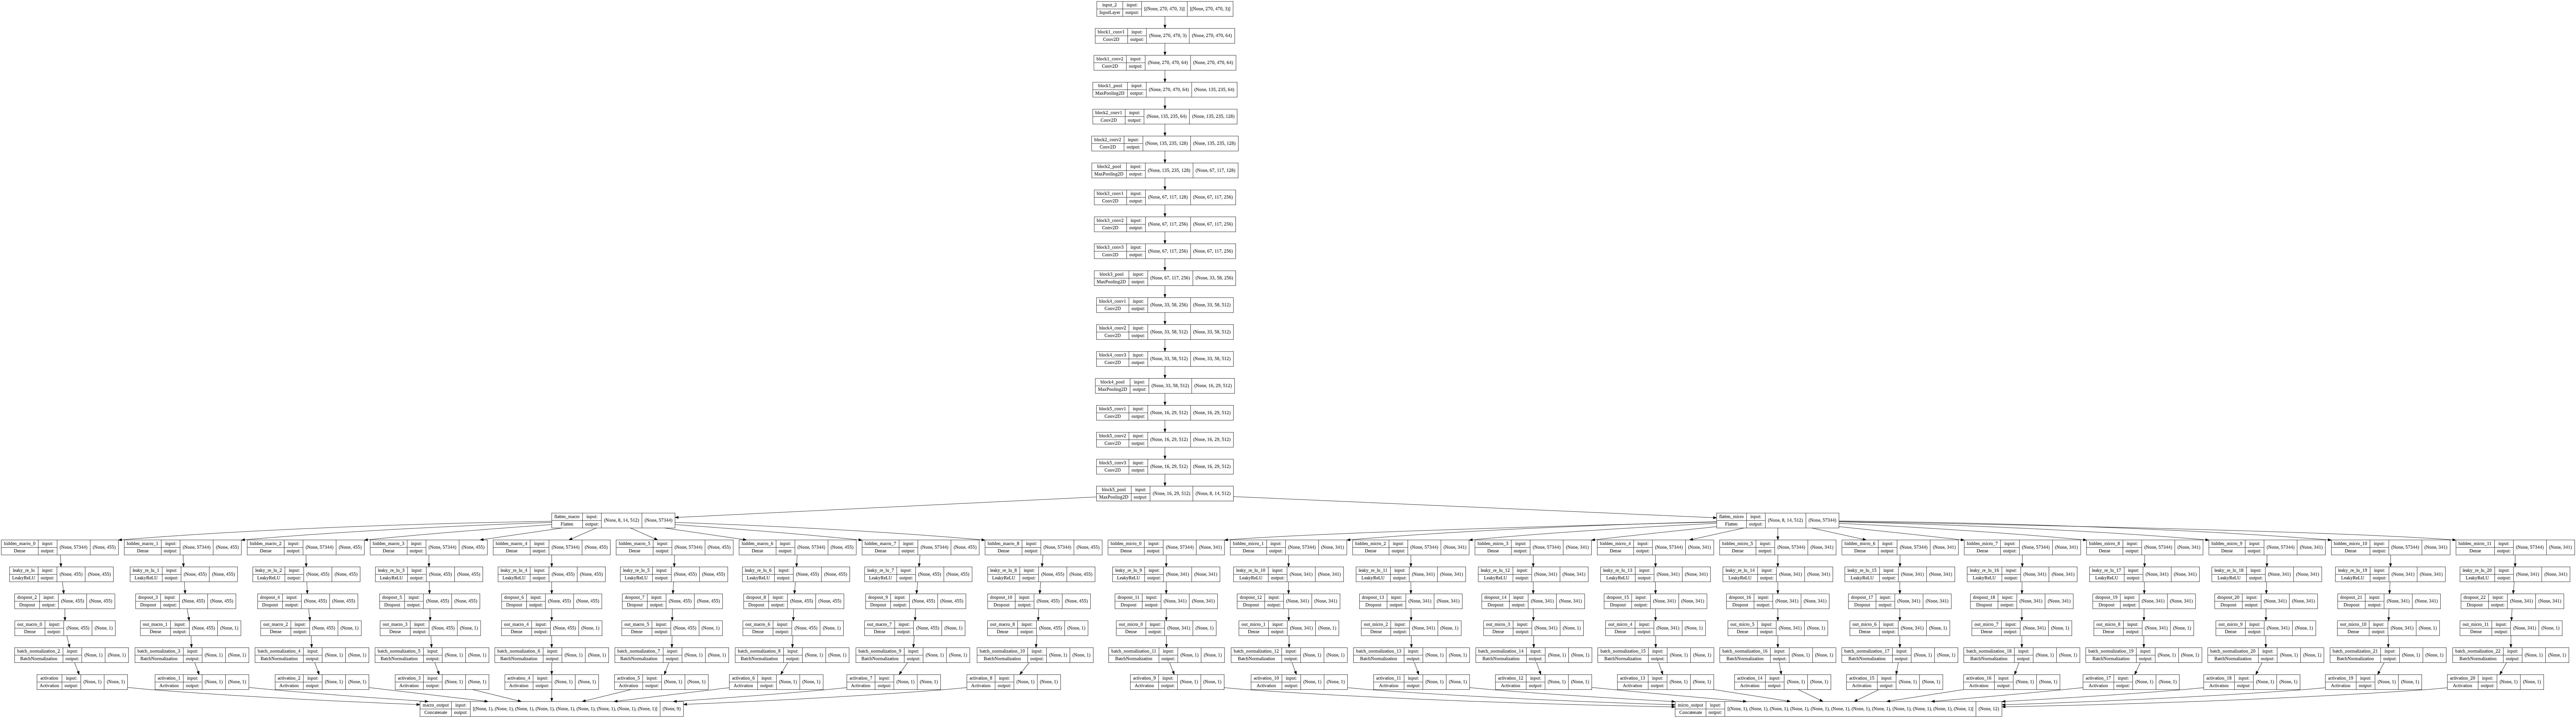

In [ ]:

from keras.layers import LeakyReLU
model_ = create_hier_model (img_shape=img_shape, 
                           n_labels_macro=10,
                           n_labels_micro=13,
                           trainable_convs=trainable_convs,
                           shared_layers=shared_layers,
                           model_head=obd)

print(model_)
print(model_.summary())
tf.keras.utils.plot_model(model_, to_file=dot_img_file, show_shapes=True)  #plot the model with the shapes


## CUSTOM ACCURACY 

In [ ]:
def custom_accuracy_wrapper(y_true, y_pred):
	y_true = y_true.numpy()
	y_pred = y_pred.numpy() 
 
	#print('\n y_true : {} - y_pred : {} '.format(y_true.shape,y_true.shape))
 
	if(y_true.shape[1] == 23):
		y_true_class, y_true_series = np.split(y_true, [10], axis=1)
		y_pred_class, y_pred_series = np.split(y_pred, [10], axis=1)
		'''
		print('\n AFTER y_true : {} - y_pred : {} '.format(y_true_class.shape,y_pred_class.shape))
		print('y_true : {}'.format(np.argmax(y_true_class,axis=1)))
		print('y_pred : {}'.format(np.argmax(y_pred_class,axis=1)))
		'''
		accuracy = sk.metrics.accuracy_score(np.argmax(y_true_class,axis=1), np.argmax(y_pred_class,axis=1), normalize=True, sample_weight=None) 
		#print(accuracy)
		return accuracy
	else: 
		y_true = np.argmax(y_true,axis=1)
		y_pred = np.argmax(y_pred,axis=1)
		#print('y_true : {},y_pred : {} '.format(y_true,y_pred))
		accuracy = sk.metrics.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None) 
		#print(accuracy)
		return accuracy
	return -1 


def custom_accuracy (y_true, y_pred):
	return tf.py_function(func=custom_accuracy_wrapper,inp=[y_true, y_pred],Tout=tf.float32)

## CODICE CUSTOM LOSS 

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
def custom_loss_wrapper(y_true, y_pred):
  tf.print(y_true)
  print(y_true.shape)
  print(y_pred.shape)
  #cce = tf.keras.losses.CategoricalCrossentropy()
  
  # Using 'none' reduction type.
  cce = tf.keras.losses.CategoricalCrossentropy()#reduction=tf.keras.losses.Reduction.SUM) #NONE, #SUM, 
  #e.g. cce(y_true, y_pred).numpy()
  #e.g. : array([0.0513, 2.303], dtype=float32)
  
  if(y_true.shape[1] == 23):
    y_true_class, y_true_series = np.split(y_true, [10], axis=1)
    print(np.shape(y_true_class))
    y_true_class_2 = tf.convert_to_tensor(y_true_class)
    print(np.shape(y_true_class_2))
    
    y_pred_class, y_pred_series = np.split(y_pred, [10], axis=1)
    print(np.shape(y_pred_class))
    y_pred_class_2 = tf.convert_to_tensor(y_pred_class)
    print(np.shape(y_pred_class_2))

    loss = cce(y_true_class_2, y_pred_class_2).numpy()
    #loss = cce(y_true, y_pred).numpy()

    tf.print(loss)
    '''
    print(type(loss))
    loss = tf.constant(loss, dtype=tf.float32)
    loss = tf.reshape(loss, [1])
    print(type(loss))
    '''
    print("OKKKKKKK-----------")

    return loss
    #return [loss,loss]

  else:
    loss = cce(y_true, y_pred).numpy()
  
    #tf.print(loss)
    '''
    print(type(loss))
    loss = tf.constant(loss, dtype=tf.float32)
    loss = tf.reshape(loss, [1])
    print(type(loss))
    '''
    return loss
  return -1 

def custom_loss(y_true, y_pred): 
	return tf.py_function(func=custom_loss_wrapper,inp=[y_true, y_pred],Tout=tf.float32)
 

'''
#ERRORE CHE VIENE USANDO LA LOSS CUSTOM è LEGATA A STO SLICE CHE FA DA SOLO: 
#https://www.tensorflow.org/api_docs/python/tf/slice

#ESEMPIO DI COME PASSARE PIU PARAMETRI A UNA FUNZIONE CUSTOM?
#https://stackoverflow.com/questions/57897080/load-custom-loss-with-extra-input-in-keras

#ESEMPIO DI CLOSURE FUNCTION - COME FANNO LORO NEL CODICE DOVE C'è UNA FUNZIONE DENTRO L'ALTRA
#https://en.wikipedia.org/wiki/Closure_(computer_programming)
#https://towardsdatascience.com/advanced-keras-constructing-complex-custom-losses-and-metrics-c07ca130a618
#https://datascience.stackexchange.com/questions/25029/custom-loss-function-with-additional-parameter-in-keras

#ESEMPIO DI UTILIZZO DEL 'GRADIENT TAPE' SE VOGLIAMO USARE LA LOSS PER LE SOLE CLASSI DI QUALITÀ
#https://pyimagesearch.com/2020/03/23/using-tensorflow-and-gradienttape-to-train-a-keras-model/

'''

"\n#ERRORE CHE VIENE USANDO LA LOSS CUSTOM è LEGATA A STO SLICE CHE FA DA SOLO: \n#https://www.tensorflow.org/api_docs/python/tf/slice\n\n#ESEMPIO DI COME PASSARE PIU PARAMETRI A UNA FUNZIONE CUSTOM?\n#https://stackoverflow.com/questions/57897080/load-custom-loss-with-extra-input-in-keras\n\n#ESEMPIO DI CLOSURE FUNCTION - COME FANNO LORO NEL CODICE DOVE C'è UNA FUNZIONE DENTRO L'ALTRA\n#https://en.wikipedia.org/wiki/Closure_(computer_programming)\n#https://towardsdatascience.com/advanced-keras-constructing-complex-custom-losses-and-metrics-c07ca130a618\n#https://datascience.stackexchange.com/questions/25029/custom-loss-function-with-additional-parameter-in-keras\n\n#ESEMPIO DI UTILIZZO DEL 'GRADIENT TAPE' SE VOGLIAMO USARE LA LOSS PER LE SOLE CLASSI DI QUALITÀ\n#https://pyimagesearch.com/2020/03/23/using-tensorflow-and-gradienttape-to-train-a-keras-model/\n\n"

##Metrica Balance Accuracy

In [ ]:
import keras.backend as K
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
'''
Funzione per Balance Accuracy 
-- Link Utile : https://medium.com/@mostafa.m.ayoub/customize-your-keras-metrics-44ac2e2980bd --
-- https://medium.com/analytics-vidhya/custom-metrics-for-keras-tensorflow-ae7036654e05 --- 
-- https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score --- 
'''


'''
#Funzione per Balance Accuracy 
def monitor_balance_accuracy ():
	def bal_acc(y_true, y_pred):
		print(y_pred)
		print(len(y_pred))
		print(type(y_pred))
		print(y_true)
		print(len(y_true))
		print(type(y_true))
		#y_true = y_true.numpy().argmax(axis=1) #Returns the indices of the maximum values along an axis.
		#y_pred = y_pred.numpy().argmax(axis=1) #Returns the indices of the maximum values along an axis.
		Balanced_Accuracy = balanced_accuracy_score(y_true, y_pred)
		Balanced_Accuracy = tf.constant(Balanced_Accuracy)
		return K.min(Balanced_Accuracy)
	return bal_acc
''' 
'''
#https://medium.com/@mostafa.m.ayoub/customize-your-keras-metrics-44ac2e2980bd
#https://www.statology.org/balanced-accuracy-python-sklearn/
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def balanced_accuracy_new (y_true, y_pred):
		#print("y_true:{}".format(y_true))
		#print("y_pred:{}".format(y_pred))
		sensitivity_ = sensitivity(y_true, y_pred)
		specificity_ = specificity(y_true, y_pred)
		BA = (sensitivity_ + specificity_) / 2
		return BA 
'''

def avg_balanced_accuracy_new (y_true, y_pred):
	return tf.py_function(func=avg_balanced_accuracy_new_wrapper,inp=[y_true, y_pred],Tout=tf.float32)

def avg_balanced_accuracy_new_wrapper (y_true, y_pred):
		#print("y_true : {}".format(y_true))
		#tf.print(y_true)	
		#print("y_pred : {}".format(y_pred))
		y_true = y_true.numpy()
		if np.shape(y_true)[1] == 13:
			return 0
		y_pred = y_pred.numpy()
	
		y_true_class, y_true_series = np.split(y_true, [10], axis=1)
		y_pred_class, y_pred_series = np.split(y_pred, [10], axis=1)
	
		'''
		print("shape y_true_class : {}".format(np.shape(y_true_class)))
		print("shape y_true_series : {}".format(np.shape(y_true_series)))
		print("shape y_batch_head : {}".format(y_true_class[1:5]))
		print("shape y_batch_head : {}".format(y_pred_class[1:5]))
		print("shape y_pred_class : {}".format(np.shape(y_pred_class)))
		print("shape y_pred_series : {}".format(np.shape(y_pred_series)))
		'''

		test_array_s0, test_array_s1, test_array_s2, test_array_s3, test_array_s4, test_array_s5, test_array_s6, test_array_s7, test_array_s8, test_array_s9, test_array_s10, test_array_s11, test_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
		pred_array_s0, pred_array_s1, pred_array_s2, pred_array_s3, pred_array_s4, pred_array_s5, pred_array_s6, pred_array_s7, pred_array_s8, pred_array_s9, pred_array_s10, pred_array_s11, pred_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
		BA = np.zeros(13)
		sum,average,count,j,i=0,0,0,0,0
		series_,true_class,pred_class = 0,0,0
		vettore = np.zeros(13)

		for (j, label1, label2, label3) in zip(range(len(y_true_series)), y_true_class, y_true_series, y_pred_class):
			true_class = np.argmax(label1,axis=0)
			#true_class = label1

			series_ = np.argmax(label2,axis=0)
	 
			pred_class = np.argmax(label3,axis=0)
			vettore[series_]=vettore[series_]+1
			#pred_class = label3
			
			#print("true_class,pred_class,series : {}-{}-{}".format(true_class,pred_class,series_))

			if series_ == 0:
				test_array_s0.append(true_class)
				pred_array_s0.append(pred_class)
			if series_ == 1:
				test_array_s1.append(true_class)
				pred_array_s1.append(pred_class)
			if series_ == 2:
				test_array_s2.append(true_class)
				pred_array_s2.append(pred_class)
			if series_ == 3:
				test_array_s3.append(true_class)
				pred_array_s3.append(pred_class)
			if series_ == 4:
				test_array_s4.append(true_class)
				pred_array_s4.append(pred_class)
			if series_ == 5:
				test_array_s5.append(true_class)
				pred_array_s5.append(pred_class)
			if series_ == 6:
				test_array_s6.append(true_class)
				pred_array_s6.append(pred_class)
			if series_ == 7:
				test_array_s7.append(true_class)
				pred_array_s7.append(pred_class)
			if series_ == 8:
				test_array_s8.append(true_class)
				pred_array_s8.append(pred_class)
			if series_ == 9:
				test_array_s9.append(true_class)
				pred_array_s9.append(pred_class)
			if series_ == 10:
				test_array_s10.append(true_class)
				pred_array_s10.append(pred_class)
			if series_ == 11:
				test_array_s11.append(true_class)
				pred_array_s11.append(pred_class)
			if series_ == 12:
				test_array_s12.append(true_class)
				pred_array_s12.append(pred_class)

		#print(vettore)	#vettore con numero di elementi per ciascuna serie geometrica
		test_array_series = [
                     test_array_s0, 
                     test_array_s1,
                     test_array_s2,
                     test_array_s3,
                     test_array_s4,
                     test_array_s5,
                     test_array_s6,
                     test_array_s7,
                     test_array_s8,
                     test_array_s9,
                     test_array_s10,
                     test_array_s11,
                     test_array_s12
                     ]

		pred_array_series = [
                     pred_array_s0, 
                     pred_array_s1,
                     pred_array_s2,
                     pred_array_s3,
                     pred_array_s4,
                     pred_array_s5,
                     pred_array_s6,
                     pred_array_s7,
                     pred_array_s8,
                     pred_array_s9,
                     pred_array_s10,
                     pred_array_s11,
                     pred_array_s12
                     ]


		for i in range (13):
			#BA[i] = balanced_accuracy_new(test_array_series[i],pred_array_series[i])
			if len(test_array_series[i])>0:
				BA[i] = sk.metrics.balanced_accuracy_score(test_array_series[i], pred_array_series[i], sample_weight=None, adjusted=False)
				sum += BA[i]
				count = count+1
			#print('Balanced Accuracy Series {0} : {1:0.4f}' . format(i, BA[i]))

		#----------- MEDIA DELLE BALANCED ACCURACY ---------------
		average = sum/count
		#print("AVG(BA) : {}".format(average))
			
		return average

## Callbacks 

In [ ]:
'''CALLBACKS'''
from keras.callbacks import ModelCheckpoint, EarlyStopping

#TEST BALANCE ACCURACY 
from sklearn.metrics import balanced_accuracy_score

#NB: create sul drive una cartella weights dove salvare i pesi durante l'allenamento
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'
'''
model_checkpoint_val_bal_acc = ModelCheckpoint(
    filepath=os.path.join('/content/drive/My Drive/ProgettoDL/weights/model_{}_{}/best_weights.h5'.format(immgs,cnn)),
     monitor='val_class_output_custom_metrics_denis', verbose=1, save_best_only=True)
'''
#---------
model_checkpoint_val_avg_bal_acc = ModelCheckpoint( 
    filepath=os.path.join('/content/drive/My Drive/ProgettoDL/weights/model_{}_{}/best_weights.h5'.format(immgs,cnn)), 
    monitor='val_class_output_avg_balanced_accuracy_new', verbose=1, save_best_only=True)
#---------

model_checkpoint_val_loss = ModelCheckpoint( 
    filepath=os.path.join('/content/drive/My Drive/ProgettoDL/weights/model_{}_{}/best_weights.h5'.format(immgs,cnn)), 
    monitor='val_loss', verbose=1, save_best_only=True)

### MODIFICATO QUA - Implementazione Early Stopping###

early_stopping_val_avg_bal_acc = tf.keras.callbacks.EarlyStopping(                          #-------------
    monitor='val_class_output_avg_balanced_accuracy_new', #Quantity to be monitored 
    min_delta=0, #Minimum change in the monitored quantity to qualify as an improvement
    patience=5, #Number of epochs with no improvement after which training will be stopped
    #verbosity mode, setting verbose 0, 1 or 2 you just say 
    #how do you want to 'see' the training progress for each epoch.
    #verbose=0 will show you nothing (silent)
    #verbose=1 will show you an animated progress bar like this: progres_bar
    verbose=0, 
    #Mode = One of {"auto", "min", "max"}. In min mode, training will stop when the quantity 
    #monitored has stopped decreasing; in "max" mode 
    #it will stop when the quantity monitored has stopped increasing; 
    #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
    mode="max",
    #Training will stop if the model doesn't show improvement over the baseline.
    baseline=None,
    #Whether to restore model weights from the epoch with the best value of the monitored quantity
    restore_best_weights=False
)
'''
early_stopping_val_bal_acc = tf.keras.callbacks.EarlyStopping(
    monitor='val_class_output_balanced_accuracy_new', #Quantity to be monitored 
    min_delta=0, #Minimum change in the monitored quantity to qualify as an improvement
    patience=5, #Number of epochs with no improvement after which training will be stopped
    #verbosity mode, setting verbose 0, 1 or 2 you just say 
    #how do you want to 'see' the training progress for each epoch.
    #verbose=0 will show you nothing (silent)
    #verbose=1 will show you an animated progress bar like this: progres_bar
    verbose=0, 
    #Mode = One of {"auto", "min", "max"}. In min mode, training will stop when the quantity 
    #monitored has stopped decreasing; in "max" mode 
    #it will stop when the quantity monitored has stopped increasing; 
    #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
    mode="max",
    #Training will stop if the model doesn't show improvement over the baseline.
    baseline=None,
    #Whether to restore model weights from the epoch with the best value of the monitored quantity
    restore_best_weights=False
)
'''
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', #Quantity to be monitored 
    min_delta=0, #Minimum change in the monitored quantity to qualify as an improvement
    patience=5,#10(perchè 2 loss) #Number of epochs with no improvement after which training will be stopped
    #verbosity mode, setting verbose 0, 1 or 2 you just say 
    #how do you want to 'see' the training progress for each epoch.
    #verbose=0 will show you nothing (silent)
    #verbose=1 will show you an animated progress bar like this: progres_bar
    verbose=0, 
    #Mode = One of {"auto", "min", "max"}. In min mode, training will stop when the quantity 
    #monitored has stopped decreasing; in "max" mode 
    #it will stop when the quantity monitored has stopped increasing; 
    #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
    mode="auto",
    #Training will stop if the model doesn't show improvement over the baseline.
    baseline=None,
    #Whether to restore model weights from the epoch with the best value of the monitored quantity
    restore_best_weights=False
)
#callbacks=[model_checkpoint_val_bal_acc, model_checkpoint_val_loss , early_stopping_val_bal_acc, early_stopping_val_loss ]
callbacks=[#model_checkpoint_val_bal_acc,
           model_checkpoint_val_avg_bal_acc, 
           model_checkpoint_val_loss ,
           #early_stopping_val_bal_acc, 
           early_stopping_val_avg_bal_acc,
           early_stopping_val_loss ]  #------------

##HYPERPARAMETERS

In [ ]:
'''HYPERPARAMETERS DEFINITION'''
#per la stampa dei tensori 
import keras.backend as K   

opt = SGD(learning_rate = 0.001, decay = 1e-4, momentum= 0.7)


num_epochs = 50 #100
bs = 64 


class_weights = weight_train
print('Class Weight Train : {} '.format(class_weights))
print('Type Class Weight Train : {} '.format(type(class_weights)))

data = list(class_weights.values())
class_weights = np.array(data)
print('Class Weight Train : {} '.format(class_weights))


losses = {
    "class_output": tf.keras.losses.CategoricalCrossentropy(),
    #"class_output": weighted_categorical_crossentropy(class_weights).loss,     #PER QUANDO BISOGNERA USARE QUESTA MAGARI POI BASTA DARE PESI 0 PER LE SERIE E L'ALLENAMENTO LO FORZI AD ANDARE COME VOGLIAMO (OPPURE TUTTO 1?)
    "series_output": tf.keras.losses.CategoricalCrossentropy()
}

lossWeights = {"class_output": 1.0, "series_output": 0.5}

#model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])  

model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=[custom_accuracy,avg_balanced_accuracy_new])    

Class Weight Train : {0: 1.34, 1: 1.53, 2: 0.97, 3: 1.16, 4: 1.15, 5: 0.71, 6: 0.62, 7: 1.02, 8: 0.75, 9: 2.05} 
Type Class Weight Train : <class 'dict'> 
Class Weight Train : [1.34 1.53 0.97 1.16 1.15 0.71 0.62 1.02 0.75 2.05] 


## Creazione TrainGen, ValGen, TestGen 

In [ ]:
traingen = CustomDataGen(train_balance_df, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class', 'GEOMETRIA': 'series'}, batch_size=bs, input_size=(270,470))     
testgen = CustomDataGen(test_balance_df, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class', 'GEOMETRIA': 'series'}, batch_size=bs, input_size=(270,470))   
valgen = CustomDataGen(val_balance_df, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class', 'GEOMETRIA': 'series'}, batch_size=bs, input_size=(270,470))

## Testing Model 

In [ ]:
'''TRAINING THE MODEL''' 
from sklearn.preprocessing import LabelBinarizer 
history = model.fit(x=traingen,validation_data=valgen, epochs=num_epochs, callbacks = [callbacks], verbose=1) 

print(history.history.keys()) #---serve per stampare le metriche che ho nel modello

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 5.6001 - class_output_loss: 4.6648 - series_output_loss: 1.8707 - class_output_custom_accuracy: 0.4128 - class_output_avg_balanced_accuracy_new: 0.3558 - series_output_custom_accuracy: 0.4786 - series_output_avg_balanced_accuracy_new: 0.0000e+00 
Epoch 1: val_class_output_avg_balanced_accuracy_new improved from -inf to 0.41994, saving model to /content/drive/My Drive/ProgettoDL/weights/model_CALCIO_NO_CROP_vgg16/best_weights.h5

Epoch 1: val_loss improved from inf to 4.85970, saving model to /content/drive/My Drive/ProgettoDL/weights/model_CALCIO_NO_CROP_vgg16/best_weights.h5
19/19 [==============================] - 807s 43s/step - loss: 5.6001 - class_output_loss: 4.6648 - series_output_loss: 1.8707 - class_output_custom_accuracy: 0.4128 - class_output_avg_balanced_accuracy_new: 0.3558 - series_output_custom_accuracy: 0.4786 - series_output_avg_balanced_accuracy_new: 0.0000e+00 - val_loss: 4.8597 - val_class_output_lo

## PLOT 

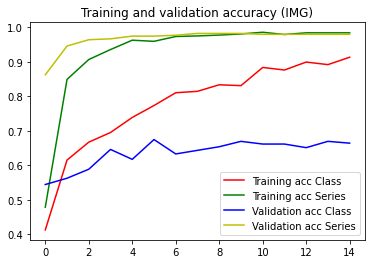

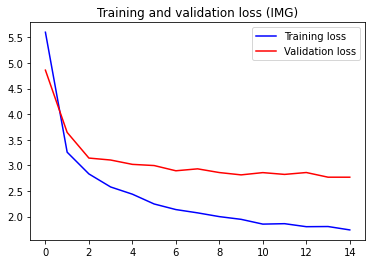

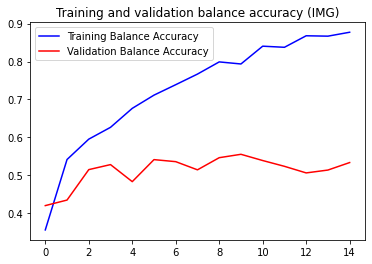

In [ ]:
'''PLOT CURVES'''

path = path_drive+'ProgettoDL/'

acc_class = history.history['class_output_custom_accuracy']
acc_series = history.history['series_output_custom_accuracy']
val_acc_class = history.history['val_class_output_custom_accuracy']
val_acc_series = history.history['val_series_output_custom_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
class_output_bal_acc = history.history['class_output_avg_balanced_accuracy_new']
val_class_output_bal_acc = history.history['val_class_output_avg_balanced_accuracy_new']
lista = [acc_class,acc_series,val_acc_class,val_acc_series,loss,val_loss,class_output_bal_acc,val_class_output_bal_acc] #--- modificato 
     
epochs = range(len(acc_class))

plt.plot(epochs, acc_class, 'r', label='Training acc Class') 
plt.plot(epochs, acc_series, 'g', label='Training acc Series') 
plt.plot(epochs, val_acc_class, 'b', label='Validation acc Class') 
plt.plot(epochs, val_acc_series, 'y', label='Validation acc Series')
plt.title('Training and validation accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotAcc_{}_{}.pdf'.format(immgs,cnn))) 

plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (IMG)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotLoss_{}_{}.pdf'.format(immgs,cnn)))

plt.figure()

plt.plot(epochs, class_output_bal_acc, 'b', label='Training Balance Accuracy')
plt.plot(epochs, val_class_output_bal_acc, 'r', label='Validation Balance Accuracy')
plt.title('Training and validation balance accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotLoss_{}_{}.pdf'.format(immgs,cnn)))

## SAVE MODEL 

In [ ]:
#salvataggio modello pesi finali
from tensorflow.keras.models import Sequential, save_model, load_model
path = path_drive+'ProgettoDL/'
model.save(os.path.join(path+'weights/model_adversarial_NO-DA_{}_{}/Final'.format(immgs,cnn)))
print("Saved model to disk")

Saved model to disk


## LOAD MODEL 

In [ ]:
'''TEST'''
import os
from tensorflow.keras.models import Sequential, save_model, load_model
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

path_model = os.path.join(path+'weights/model_adversarial_NO-DA_{}_{}/Final'.format(immgs,cnn))

model = load_model(path_model, custom_objects={
      'avg_balanced_accuracy_new':avg_balanced_accuracy_new, 
      'custom_accuracy': custom_accuracy})  #senza Weighted_CCE


print('Model Loaded')

Model Loaded


## PREDICTION 

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras import Model
from keras.applications.vgg16 import preprocess_input

test_array = []
test_array_series = []

for index, row in test_balance_df.iterrows():
    class_ = int(row['class'])
    series_ = int(row['series'])          #---da qui e nei prossimi, calcolo la ground thruth del shotgun series, ovvero i semplici COD_COMPONENTE (serie) che appartengono al sub-set di test
    test_array.append(class_)
    test_array_series.append(series_)     #---

test_array = np.array(test_array)
test_array_series = np.array(test_array_series)   #---

y_test = to_categorical(np.unique(test_array, return_inverse=True)[1])
y_test_series = to_categorical(np.unique(test_array_series, return_inverse=True)[1])      #---

imgs_array = [] 


for index, row in testgen.df.iterrows():
    filename = row['filename'] 
    image = load_img(os.path.join(path_IMAGES,filename), target_size = (immg_rows, immg_cols))
    x = img_to_array(image)
    x = preprocess_input(x, data_format="channels_first")  #non dovrebbe servire
    imgs_array.append(x)
    X_test = np.asarray(imgs_array)


In [ ]:
######PARTE DA FINIRE DI SISTEMARE
y_test_no_argmax = y_test

y_test = y_test.argmax(axis=1)
y_test_series = y_test_series.argmax(axis=1)      

'''predictions'''
y_pred = model.predict(X_test)


#----------------------SE TOGLI QUESTA RIGA, METTI LA RIGA COMMENTATA SOTTO--------------------
#----------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------
y_pred_class, y_pred_series = np.split(y_pred[0], [10], axis=1)

#y_pred_class = y_pred
#----------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------


#---------------
#metriche nuove senza usare argmax.
#---------------
#y_pred_no_argmax = y_pred[0]            #--- modificato qua aggiungendo y_pred[0] invece di y_pred
#y_pred = np.argmax(y_pred[0],axis=1)    #--- modificato qua aggiungendo y_pred[0] invece di y_pred

y_pred_no_argmax = y_pred_class          #--- modificato qua aggiungendo y_pred[0] invece di y_pred
y_pred_class = np.argmax(y_pred_class,axis=1)    #--- modificato qua aggiungendo y_pred[0] invece di y_pred

print(y_pred_class)
print(y_test)

print(y_pred_no_argmax.shape)
print(y_test_no_argmax.shape)

#y_pred_conf = model.predict(X_test)
#index = np.where(np.equal(y_pred, y_test) == False)[0]
#print(np.around(y_pred_conf[index], decimals = 2))

"""
#alcune verifiche visive sull'intero sub-set di test
print(y_test)
print(y_test.shape)
print(y_test_series)
print(y_test_series.shape)
print(y_pred)
print(y_pred.shape)
"""

[1 0 0 0 0 0 0 0 0 0 1 1 9 7 2 0 5 5 1 3 5 5 8 8 6 6 4 4 5 6 0 0 9 9 6 6 4
 4 8 8 6 6 4 4 4 4 1 1 0 0 5 5 4 4 1 2 0 0 8 8 0 0 8 8 7 7 3 2 7 7 6 6 4 4
 1 3 6 6 8 8 1 1 1 3 5 5 7 9 7 7 8 8 0 2 6 6 5 4 0 0 6 6 6 6 8 8 6 6 7 9 5
 6 6 6 8 9 8 8 9 9 6 6 5 6 2 2 4 4 1 3 6 6 0 2 2 2 8 8 6 6 3 1 1 3 1 1 8 8
 9 8 1 0 1 1 4 4 3 3 4 9 5 5 6 7 8 8 8 8 4 4 8 8 6 6 4 4 2 2 8 8 9 9 5 6 1
 1 5 5 6 6 5 5 5 5 6 6 5 5 3 3 4 4 2 2 6 6 0 0 6 6 0 0 4 4 2 2 4 4 8 8 1 0
 5 5 0 0 0 0 9 9 8 8 8 8 8 8 6 6 6 6 3 3 2 2 1 0 0 0 9 9 1 1 8 8 0 0 6 6 4
 4 8 8 8 8 5 4 6 6 1 3 5 6 1 3 4 4 6 6 6 6 1 2 6 6 4 4 8 8 8 8 1 0 1 0 4 4
 5 5 8 8 8 8 2 2 5 5 7 9 5 5 4 4 6 6 5 6 1 1 4 4 8 8 3 2 9 9 4 9 6 6 9 7 4
 4 6 6 7 9 2 2 9 9 6 6 2 2 6 6 1 3 3 3 5 5 5 5 0 0 6 6 7 9 5 6 8 8 5 5 9 9
 5 5 8 8 5 6 8 8 1 3 8 8 8 8 9 9 9 9 7 7 1 4 5 5 4 4 1 3 0 0 8 8 1 4 8 8 3
 2 6 5 9 7 1 1 5 6 1 1 5 5 6 6 4 4]
[0 0 0 4 0 0 0 0 0 0 0 1 7 7 0 0 5 5 1 3 5 5 8 8 6 6 3 4 6 6 0 0 7 8 7 6 4
 4 8 8 5 6 4 5 4 4 1 1 0 2 5 5 4 4 1 1 0 0 8 7 0 0 7 8 7 7 1 3 7

"\n#alcune verifiche visive sull'intero sub-set di test\nprint(y_test)\nprint(y_test.shape)\nprint(y_test_series)\nprint(y_test_series.shape)\nprint(y_pred)\nprint(y_pred.shape)\n"

In [ ]:
print(y_test)
print(y_test.shape)
print(y_test_series)
print(y_test_series.shape)
print(y_pred)
print(y_pred_class.shape)

[0 0 0 4 0 0 0 0 0 0 0 1 7 7 0 0 5 5 1 3 5 5 8 8 6 6 3 4 6 6 0 0 7 8 7 6 4
 4 8 8 5 6 4 5 4 4 1 1 0 2 5 5 4 4 1 1 0 0 8 7 0 0 7 8 7 7 1 3 7 7 6 7 4 4
 3 3 6 6 7 8 2 1 1 2 5 5 7 8 7 8 7 8 3 3 6 6 6 5 0 0 5 5 6 6 9 9 5 5 6 6 5
 6 5 6 9 9 8 8 9 9 6 6 5 5 2 2 2 2 0 1 6 6 2 2 1 1 8 8 6 6 3 3 1 1 1 1 9 9
 7 7 1 1 1 1 4 4 2 2 4 4 5 5 5 5 8 8 8 8 3 3 8 8 5 6 2 2 2 2 8 8 9 9 5 5 1
 1 5 5 6 6 5 5 5 5 6 6 5 5 3 3 5 5 1 1 6 6 0 0 6 6 0 2 4 4 2 2 4 4 8 8 0 2
 5 5 0 0 0 0 9 9 8 8 7 7 7 8 6 6 5 5 1 1 2 2 0 0 1 1 9 9 1 1 9 9 4 0 6 6 4
 4 8 8 6 8 5 5 6 6 1 2 5 6 3 3 3 3 6 6 6 6 1 2 6 5 4 4 7 7 6 7 1 1 0 0 4 5
 6 6 8 8 8 8 2 2 6 5 7 7 5 5 4 4 6 6 5 6 2 1 4 4 8 7 2 2 7 7 4 4 6 6 8 8 3
 3 6 6 7 7 2 2 9 8 6 6 2 1 7 8 2 3 3 3 5 5 6 6 0 0 5 6 7 7 5 6 7 8 2 5 8 9
 5 4 7 8 6 6 8 8 2 2 7 7 7 8 9 9 9 9 9 7 3 3 5 5 5 4 1 3 2 3 8 8 4 4 7 7 3
 3 5 5 7 7 2 2 6 6 1 1 5 5 6 6 5 5]
(424,)
[ 3  3  3  3  3  3  3  3  3  3  7  7 11 11  3  3  2  2  7  7  2  2  4  4
  3  3  6  6 12 12  3  3  8  8  0  0  6  6  4  4  0  0  6  

##SEARCH UNIVOQUE SERIES TO BALANCE SETS

In [ ]:
'''SEARCHING UNIVOQUE SERIES'''

'''serve per fare le stampe delle confusion matrix per ciascuna serie di appartenenza delle immagini del sub-set test'''
test_array_s0, test_array_s1, test_array_s2, test_array_s3, test_array_s4, test_array_s5, test_array_s6, test_array_s7, test_array_s8, test_array_s9, test_array_s10, test_array_s11, test_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
pred_array_s0, pred_array_s1, pred_array_s2, pred_array_s3, pred_array_s4, pred_array_s5, pred_array_s6, pred_array_s7, pred_array_s8, pred_array_s9, pred_array_s10, pred_array_s11, pred_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
i=0
for index, row in test_balance_df.iterrows():
    
    series_ = int(row['series'])
    if series_ == 0:
      test_array_s0.append(y_test[i])
      pred_array_s0.append(y_pred_class[i])
    if series_ == 1:
      test_array_s1.append(y_test[i])
      pred_array_s1.append(y_pred_class[i])
    if series_ == 2:
      test_array_s2.append(y_test[i])
      pred_array_s2.append(y_pred_class[i])
    if series_ == 3:
      test_array_s3.append(y_test[i])
      pred_array_s3.append(y_pred_class[i])
    if series_ == 4:
      test_array_s4.append(y_test[i])
      pred_array_s4.append(y_pred_class[i])
    if series_ == 5:
      test_array_s5.append(y_test[i])
      pred_array_s5.append(y_pred_class[i])
    if series_ == 6:
      test_array_s6.append(y_test[i])
      pred_array_s6.append(y_pred_class[i])
    if series_ == 7:
      test_array_s7.append(y_test[i])
      pred_array_s7.append(y_pred_class[i])
    if series_ == 8:
      test_array_s8.append(y_test[i])
      pred_array_s8.append(y_pred_class[i])
    if series_ == 9:
      test_array_s9.append(y_test[i])
      pred_array_s9.append(y_pred_class[i])
    if series_ == 10:
      test_array_s10.append(y_test[i])
      pred_array_s10.append(y_pred_class[i])
    if series_ == 11:
      test_array_s11.append(y_test[i])
      pred_array_s11.append(y_pred_class[i])
    if series_ == 12:
      test_array_s12.append(y_test[i])
      pred_array_s12.append(y_pred_class[i])

    i=i+1

print(test_array_s0)
print(pred_array_s0)

from functools import reduce
reduced = reduce(np.union1d, (pred_array_s0, test_array_s0))
print(reduced)

[7, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 5, 6, 6]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[5 6 7]


## METRICHE MASK & IMG 

In [ ]:
'''METRICHE'''
print('--------------Metrice IMG----------------')

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix


a = accuracy_score(y_test, y_pred_class)                                              # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("test accuracy: {0:0.4f}".format(a))
print("precision: {0:0.4f}".format(precision_score(y_test, y_pred_class, average="macro")))         # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html?highlight=precision_score#sklearn.metrics.precision_score
print("recall: {0:0.4f}".format(recall_score(y_test, y_pred_class, average="macro")))                # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score#sklearn.metrics.recall_score
print("f1_score: {0:0.4f}".format(f1_score(y_test, y_pred_class, average="macro")))                # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score
print('---------------------------------------')
print('classification report:')
print(classification_report(y_test, y_pred_class))  



--------------Metrice IMG----------------
test accuracy: 0.6415
precision: 0.6268
recall: 0.6254
f1_score: 0.6069
---------------------------------------
classification report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75        37
           1       0.59      0.62      0.60        39
           2       0.62      0.42      0.50        38
           3       0.50      0.39      0.44        28
           4       0.58      0.83      0.68        35
           5       0.78      0.61      0.68        64
           6       0.75      0.81      0.78        69
           7       0.71      0.28      0.40        43
           8       0.59      0.83      0.69        48
           9       0.47      0.65      0.55        23

    accuracy                           0.64       424
   macro avg       0.63      0.63      0.61       424
weighted avg       0.65      0.64      0.63       424



Per quanto riguarda la funzione np_quadratic_weighted_kappa abbiamo avuto alcune difficoltà implementative e quindi abbiamo cercato un codice online che ci calcolasse la stessa metrica 

[Link Utilizzato](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps)

In [ ]:

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=1 # era None abbiamo messo 0
    max_rating=9 # era None abbiamo messo 9
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [ ]:
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

os.chdir(path)

from metrics import np_quadratic_weighted_kappa, minimum_sensitivity
from sklearn.metrics import mean_absolute_error

#errore no graph before run 
tf.compat.v1.disable_eager_execution()

def compute_metrics(y_true, y_pred, num_classes):
  #run function minimum_sensitivity
  # Calculate metric
  sess = keras.backend.get_session()

  #qwk = np_quadratic_weighted_kappa(np.argmax(y_true, axis=0), np.argmax(y_pred, axis=0), 0,
	#									num_classes - 1)
  
  qwk = quadratic_weighted_kappa(y_true, y_pred_class)
  ms = minimum_sensitivity(y_test_no_argmax, y_pred_no_argmax)
  mae = sess.run(K.mean(keras.losses.mean_absolute_error(y_test_no_argmax, y_pred_no_argmax)))
  
  metrics = {
		'QWK': qwk,
		'MS': ms,
		'MAE': mae}
  
  return metrics

def print_metrics(metrics):
	print('QWK: {:.4f}'.format(metrics['QWK']))
	print('MS: {:.4f}'.format(metrics['MS']))
	print('MAE: {:.4f}'.format(metrics['MAE']))    


#-----codice------
num_classi = 10
metrics = compute_metrics(y_test, y_pred,num_classi)
print_metrics(metrics)

with open("metrics.txt", "w") as text_file:
    print(print_metrics, file=text_file)

QWK: 0.7560
MS: 0.2791
MAE: 0.0833


***Metrice Ottenute***

**K Cohen**   https://it.vvikipedla.com/wiki/Cohen%27s_kappa
Il Kappa di Cohen è un coefficiente statistico che rappresenta il grado di accuratezza e affidabilità in una classificazione statistica; è un indice di concordanza che tiene conto della probabilità di concordanza casuale; l'indice calcolato in base al rapporto tra l'accordo in eccesso rispetto alla probabilità di concordanza casuale e l'eccesso massimo ottenibile. Attraverso la matrice di confusione è possibile valutare questo parametro. In particolare ... Esistono diversi "gradi di concordanza", in base ai quali possiamo definire se Kappa di Cohen è scarso o ottimo:

- se k assume valori inferiori a 0, allora non c'è concordanza;
- se k assume valori compresi tra 0-0,4, allora la concordanza è scarsa;
- se k assume valori compresi tra 0,4-0,6, allora la concordanza è discreta;
- se k assume valori compresi tra 0,6-0,8, la concordanza è buona;
- se k assume valori compresi tra 0,8-1, la concordanza è ottima.

**QWK**: 0.7849

BLA BLA BLA 

**MS**: 1.0000


In statistics, **mean absolute error (MAE)** is a measure of errors between paired observations expressing the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. 

**MAE**: 0.0000

## PLOT CONFUSION MATRIX FUNCTION 

In [ ]:
'''METHOD FOR PLOT CONFUSION MATRIX'''
#Confusion Matrix - CROP
import sklearn.metrics as metrics

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    axes = plt.gca()
    bottom, top = axes.get_ylim()
    axes.set_ylim(bottom + 0.5, top - 0.5)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    return fig




## PLOT CONFUSION MATRIX 

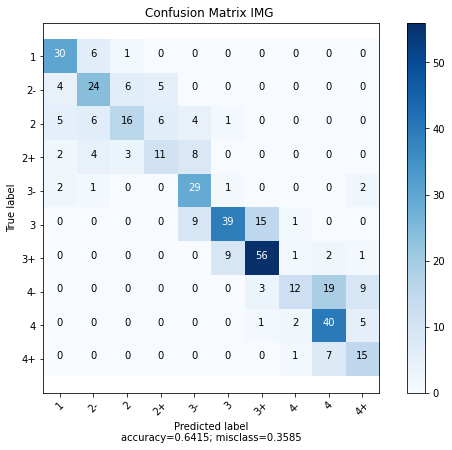

In [ ]:
'''PLOT ENTIRE CONFUSION MATRIX OF THE SUB-SET TEST'''

import sklearn.metrics as metrics
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_class)
fig = plot_confusion_matrix(cm,
                      target_names = classi,
                      normalize    = False,
                      title        = "Confusion Matrix IMG ")
fig.savefig(os.path.join(path+'weights/CM_{}_{}.pdf'.format(immgs,cnn))) 

##PLOT CONFUSION MATRIX PER CIASCUNA SERIE DEL CALCIO 

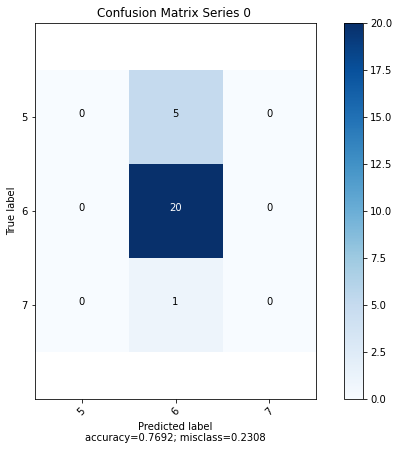

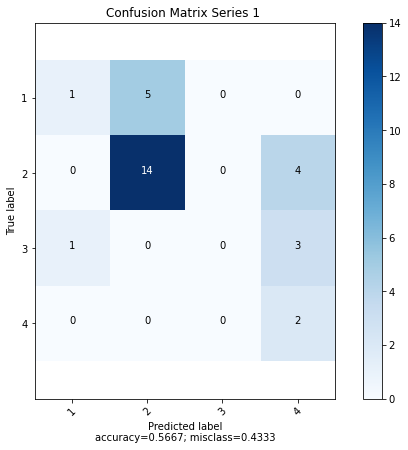

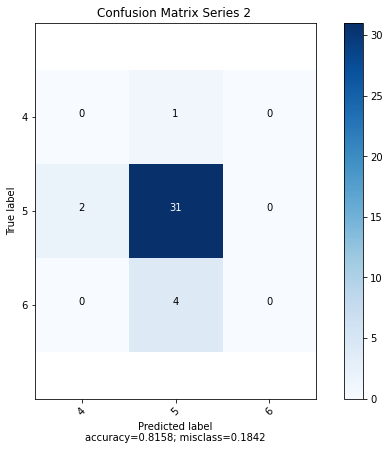

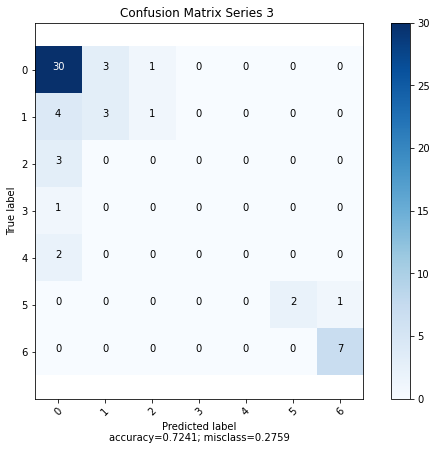

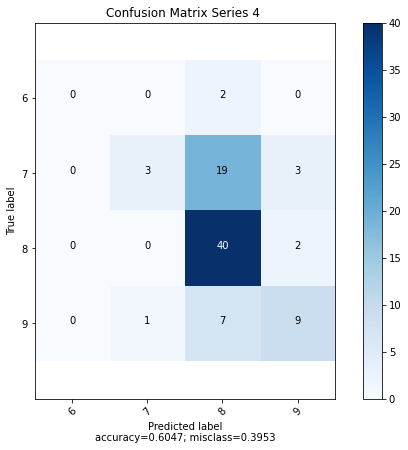

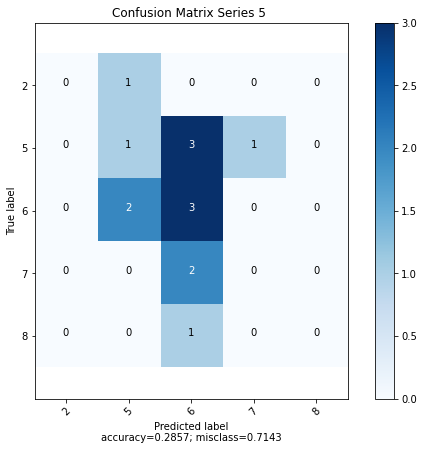

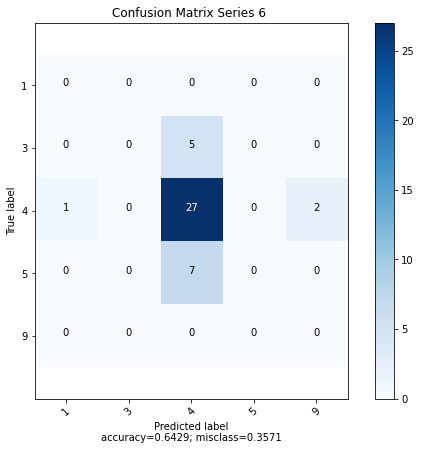

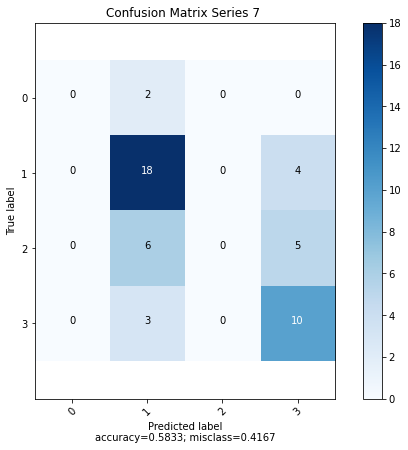

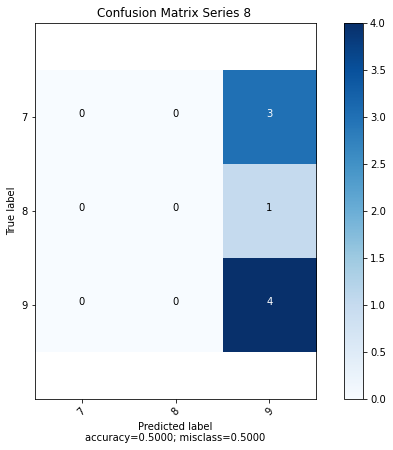

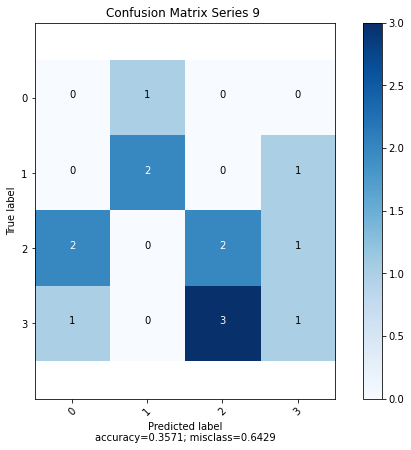

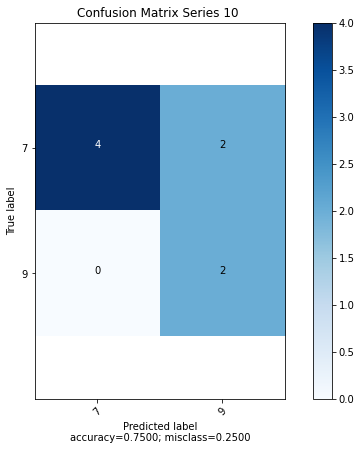

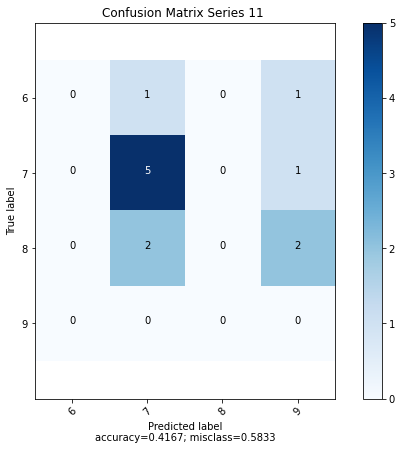

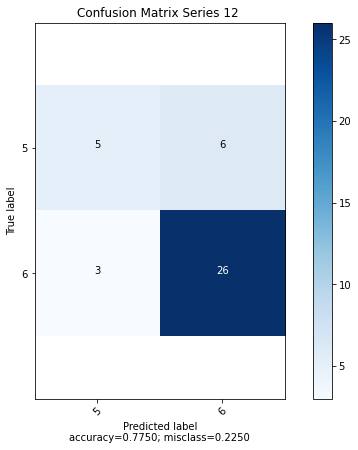

In [ ]:
'''PLOT CONFUSION MATRIX FOR EACH DISTINCT SERIES OF PRODUCTION PRESENT INTO THE SUB-SET TEST'''

import sklearn.metrics as metrics
from functools import reduce
#serie 0
cm0 = metrics.confusion_matrix(y_true=test_array_s0, y_pred=pred_array_s0)
fig = plot_confusion_matrix(cm0,
                      target_names = reduce(np.union1d, (pred_array_s0, test_array_s0)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 0 ")
fig.savefig(os.path.join(path+'weights/CM_serie0_{}_{}.pdf'.format(immgs,cnn))) 

#serie 1
cm1 = metrics.confusion_matrix(y_true=test_array_s1, y_pred=pred_array_s1)
fig = plot_confusion_matrix(cm1,
                      target_names = reduce(np.union1d, (pred_array_s1, test_array_s1)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 1 ")
fig.savefig(os.path.join(path+'weights/CM_serie1_{}_{}.pdf'.format(immgs,cnn))) 

#serie 2
cm2 = metrics.confusion_matrix(y_true=test_array_s2, y_pred=pred_array_s2)
fig = plot_confusion_matrix(cm2,
                      target_names = reduce(np.union1d, (pred_array_s2, test_array_s2)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 2 ")
fig.savefig(os.path.join(path+'weights/CM_serie2_{}_{}.pdf'.format(immgs,cnn))) 

#serie 3
cm3 = metrics.confusion_matrix(y_true=test_array_s3, y_pred=pred_array_s3)
fig = plot_confusion_matrix(cm3,
                      target_names = reduce(np.union1d, (pred_array_s3, test_array_s3)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 3 ")
fig.savefig(os.path.join(path+'weights/CM_serie3_{}_{}.pdf'.format(immgs,cnn))) 

#serie 4
cm4 = metrics.confusion_matrix(y_true=test_array_s4, y_pred=pred_array_s4)
fig = plot_confusion_matrix(cm4,
                      target_names = reduce(np.union1d, (pred_array_s4, test_array_s4)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 4 ")
fig.savefig(os.path.join(path+'weights/CM_serie4_{}_{}.pdf'.format(immgs,cnn))) 

#serie 5
cm5 = metrics.confusion_matrix(y_true=test_array_s5, y_pred=pred_array_s5)
fig = plot_confusion_matrix(cm5,
                      target_names = reduce(np.union1d, (pred_array_s5, test_array_s5)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 5 ")
fig.savefig(os.path.join(path+'weights/CM_serie5_{}_{}.pdf'.format(immgs,cnn))) 

#serie 6
cm6 = metrics.confusion_matrix(y_true=test_array_s6, y_pred=pred_array_s6)
fig = plot_confusion_matrix(cm6,
                      target_names = reduce(np.union1d, (pred_array_s6, test_array_s6)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 6 ")
fig.savefig(os.path.join(path+'weights/CM_serie6_{}_{}.pdf'.format(immgs,cnn))) 

#serie 7
cm7 = metrics.confusion_matrix(y_true=test_array_s7, y_pred=pred_array_s7)
fig = plot_confusion_matrix(cm7,
                      target_names = reduce(np.union1d, (pred_array_s7, test_array_s7)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 7 ")
fig.savefig(os.path.join(path+'weights/CM_serie7_{}_{}.pdf'.format(immgs,cnn))) 

#serie 8
cm8 = metrics.confusion_matrix(y_true=test_array_s8, y_pred=pred_array_s8)
fig = plot_confusion_matrix(cm8,
                      target_names = reduce(np.union1d, (pred_array_s8, test_array_s8)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 8 ")
fig.savefig(os.path.join(path+'weights/CM_serie8_{}_{}.pdf'.format(immgs,cnn))) 

#serie 9 
cm9 = metrics.confusion_matrix(y_true=test_array_s9, y_pred=pred_array_s9)
fig = plot_confusion_matrix(cm9,
                      target_names = reduce(np.union1d, (pred_array_s9, test_array_s9)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 9 ")
fig.savefig(os.path.join(path+'weights/CM_serie9_{}_{}.pdf'.format(immgs,cnn))) 

#serie 10
cm10 = metrics.confusion_matrix(y_true=test_array_s10, y_pred=pred_array_s10)
fig = plot_confusion_matrix(cm10,
                      target_names = reduce(np.union1d, (pred_array_s10, test_array_s10)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 10 ")
fig.savefig(os.path.join(path+'weights/CM_serie10_{}_{}.pdf'.format(immgs,cnn))) 

#serie 11
cm11 = metrics.confusion_matrix(y_true=test_array_s11, y_pred=pred_array_s11)
fig = plot_confusion_matrix(cm11,
                      target_names = reduce(np.union1d, (pred_array_s11, test_array_s11)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 11 ")
fig.savefig(os.path.join(path+'weights/CM_serie11_{}_{}.pdf'.format(immgs,cnn))) 

#serie 12
cm12 = metrics.confusion_matrix(y_true=test_array_s12, y_pred=pred_array_s12)
fig = plot_confusion_matrix(cm12,
                      target_names = reduce(np.union1d, (pred_array_s12, test_array_s12)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 12 ")
fig.savefig(os.path.join(path+'weights/CM_serie12_{}_{}.pdf'.format(immgs,cnn))) 

## CRAMER V CORRELATION

In [ ]:
'''CRAMER V CORRELATION MEASUREMENT'''

'''PRIMA VERSIONE'''
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(y_test, y_pred_class)
cramer1 = cramers_v(confusion_matrix.values)
print('cramer correlation tra predizioni delle classi, e le classi effettive : {:.4f}'.format(cramer1))

confusion_matrix2 = pd.crosstab(y_test_series, y_pred_class)
cramer2 = cramers_v(confusion_matrix2.values)
print('cramer correlation tra predizioni delle classi e le ground thruth di shotgun series : {:.4f}'.format(cramer2))


cramer correlation tra predizioni delle classi, e le classi effettive : 0.6173
cramer correlation tra predizioni delle classi e le ground thruth di shotgun series : 0.7330


In [ ]:
'''CRAMER V CORRELATION MEASUREMENT'''
'''SECONDA VERSIONE.        https://www.youtube.com/watch?v=eTnLTJer_Oo'''
contTable = pd.crosstab(y_test_series, y_pred_class)
print(contTable)

!pip install researchpy

import researchpy

crosstab, res = researchpy.crosstab(pd.Series(y_test_series), pd.Series(y_pred_class), test='chi-square')
print("\n{}".format(res))

df = min(contTable.shape[0], contTable.shape[1]) - 1
print("\ndf = {}".format(df))

V = res.iloc[2,1]
print("V = {}".format(V))

if df == 1:
    if V < 0.10:
        qual = 'negligible'
    elif V < 0.30:
        qual = 'small'
    elif V < 0.50:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 2:
    if V < 0.07:
        qual = 'negligible'
    elif V < 0.21:
        qual = 'small'
    elif V < 0.35:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 3:
    if V < 0.06:
        qual = 'negligible'
    elif V < 0.17:
        qual = 'small'
    elif V < 0.29:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 4:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.15:
        qual = 'small'
    elif V < 0.25:
        qual = 'medium'
    else:
        qual = 'large'
else:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.13:
        qual = 'small'
    elif V < 0.22:
        qual = 'medium'
    else:
        qual = 'large'

print("\nquality classification of the correlation is:   {}".format(qual))


col_0   0   1   2   3   4   5   6  7   8   9
row_0                                       
0       0   0   0   0   0   0  26  0   0   0
1       0   2  19   0   9   0   0  0   0   0
2       0   0   0   0   2  36   0  0   0   0
3      40   6   2   0   0   2   8  0   0   0
4       0   0   0   0   0   0   0  4  68  14
5       0   0   0   0   0   4   9  1   0   0
6       0   1   0   0  39   0   0  0   0   2
7       0  29   0  19   0   0   0  0   0   0
8       0   0   0   0   0   0   0  0   0   8
9       3   3   5   3   0   0   0  0   0   0
10      0   0   0   0   0   0   0  4   0   4
11      0   0   0   0   0   0   0  8   0   4
12      0   0   0   0   0   8  32  0   0   0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

                  Chi-square test    results
0  Pearson Chi-square ( 108.0) =   2114.8599
1                      p-value =      0.0000
2                   Cramer's V =      0.7445

df = 9
V = 0.7445

quality classification of

To indicate the strength of the association between two nominal variables, Cramér's V (Cramér, 1946) is often used.

As for the interpretation for Cramér's V various rules of thumb exist but one of them is from Cohen (1988, pp. 222, 224, 225) who let's the interpretation depend on the degrees of freedom, shown in the table below.

|df*|negligible|small|medium|large|
|-------|---|---|---|---|
|1|0 < .10|.10 < .30|.30 < .50|.50 or more|
|2|0 < .07|.07 < .21|.21 < .35|.35 or more|
|3|0 < .06|.06 < .17|.17 < .29|.29 or more|
|4|0 < .05|.05 < .15|.15 < .25|.25 or more|
|5|0 < .05|.05 < .13|.13 < .22|.22 or more|

The degrees of freedom (df*) is for Cramér's V the minimum of the number of rows, or number of columns, then minus one.

Lets see how to obtain Cramér's V with Python, using an example.




**A SECONDA DEI RISULTATI E CONFRONTANDOLI CON LA TABELLA RIUSCIAMO A CAPIRE L'INTENSITA' DEL BIAS TRA DIVERSE VARIABILI**

## Metriche Nuove

## Alcune Definizioni 


*  **True Positives** (TP): Items where the true label is positive and whose class is correctly predicted to be positive.
*  **False Positives** (FP): Items where the true label is negative and whose class is incorrectly predicted to be positive
*  **True Negatives** (N): Items where the true label is negative and whose class is correctly predicted to be negative.
*  **False Negatives** (FN): Items where the true label is positive and whose class is incorrectly predicted to be negative.

* **False Positive Rate**, or *Type I Error*: Number of items wrongly identified as positive out of the total actual negatives — FP/(FP+TN) - This error means that an image not containing a particular parasite egg is incorrectly labeled as having it
* **False Negative Rate**, or *Type II Error*: Number of items wrongly identified as negative out of the total actual positives — FN/(FN+TP). This metric is especially important to us, as it tells us the frequency with which a particular parasite egg is not classified correctly

-------------

* **Statistical Parity Difference**
This measure is based on the following formula :
𝑃𝑟(𝑌=1|𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑)−𝑃𝑟(𝑌=1|𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑) Here the bias or statistical imparity is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1. So it has to be close to 0 so it will be fair.

*  **Equal Opportunity Difference** This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group so it follows this formula - 𝑇𝑃𝑅𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑−𝑇𝑃𝑅𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑 Same as the previous metric we need it to be close to 0.

* **demographic parity** A fairness metric that is satisfied if the results of a model's classification are not dependent on a given sensitive attribute.

* **equality of opportunity** A fairness metric that checks whether, for a preferred label (one that confers an advantage or benefit to a person) and a given attribute, a classifier predicts that preferred label equally well for all values of that attribute. In other words, equality of opportunity measures whether the people who should qualify for an opportunity are equally likely to do so regardless of their group membership.

## Codice Metriche Nuove

In [ ]:
!pip install fairlearn 
from fairlearn.metrics import selection_rate
from fairlearn.metrics import true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate
from fairlearn.metrics import equalized_odds_difference

import sklearn as sk


#---- metriche lisa ----#
y_true = testgen.df['class'].to_numpy()
SR = selection_rate(y_true, y_pred_class, pos_label=1, sample_weight=None)
print('selection_rate : {}' . format(SR))


#Per quanto riguarda AO come metrica, potremo utilizzare i risultati della confusion matrix ?
#LINK : https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
#LINK : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
#print('Unique Element Y_test : {}'.format(np.unique(y_test)))
#print('Unique Element Y_pred : {}'.format(np.unique(y_pred)))
#print('True_Positive_Rate : {}'.format(true_positive_rate(y_true, y_pred)))

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('TPR : {}'.format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('TNR : {}'.format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('PPV : {}'.format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print('NPV : {}'.format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('FPR : {}'.format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print('FNR : {}'.format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print('FDR : {}'.format(FDR))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy : {}'.format(ACC))


AO = 0.5*(
    (TPR[0] + FPR[0]) - 
    (TPR[1] + FPR[1]) + 
    (TPR[2] + FPR[2]) - 
    (TPR[3] + FPR[3]) +
    (TPR[4] + FPR[4]) -
    (TPR[5] + FPR[5]) +
    (TPR[6] + FPR[6]) -
    (TPR[7] + FPR[7]) +
    (TPR[8] + FPR[8]) -
    (TPR[9] + FPR[9]))

print('AO : {}'.format(AO))
#y_true= y_true.reshape(1,-1)
#y_pred= y_pred.reshape(-1,1)
#print(y_true.shape)
#print(y_pred.shape)


'''FORSE QUA RIUSCIAMO A TROVARE UN ESEMPIO DI APPLICAZIONE DEL METODO'''
'''https://deepnote.com/@Machine-Learning-2/Miniproject-z523fGqWSSu7QV34n_u7OA'''
'''https://fairlearn.org/main/user_guide/assessment.html'''


EO =(TPR[0] - TPR[1] + TPR[2] - TPR[3] + TPR[4] - TPR[5] + TPR[6] - TPR[7] + TPR[8] - FPR[9]) 
print('EO : {}' . format(EO))


#Demographic parity
'''
Demographic parity is one of the most popular fairness indicators in the literature. 
Demographic parity is achieved if the absolute number of positive predictions 
in the subgroups are close to each other. This measure does not take true class into
consideration and only depends on the model predictions. In some literature, 
demographic parity is also referred to as statsictal parity or independence.
'''
DP = (TP + FP)
print('Demographic parity : {}' . format(DP))

#Equalized odds
'''
Equalized odds, also known as separation, are achieved if the sensitivities in the 
subgroups are close to each other. The group-specific sensitivities 
indicate the number of the true positives divided by the total 
number of positives in that group.
'''
Equalized_Odds = TP / (TP + FN)
print('Equalized Odds : {}' . format(Equalized_Odds))


##---- Link Riccardo ----##
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html


Balanced_Accuracy = sk.metrics.balanced_accuracy_score(y_true, y_pred_class, sample_weight=None, adjusted=False)
print('Balanced Accuracy Generale : {0:0.4f}' . format(Balanced_Accuracy))


#####----------- PER CIASCUNA SERIE BALANCED ACCURACY -----------####
test_array_series = [
                     test_array_s0, 
                     test_array_s1,
                     test_array_s2,
                     test_array_s3,
                     test_array_s4,
                     test_array_s5,
                     test_array_s6,
                     test_array_s7,
                     test_array_s8,
                     test_array_s9,
                     test_array_s10,
                     test_array_s11,
                     test_array_s12
                     ]

pred_array_series = [
                     pred_array_s0, 
                     pred_array_s1,
                     pred_array_s2,
                     pred_array_s3,
                     pred_array_s4,
                     pred_array_s5,
                     pred_array_s6,
                     pred_array_s7,
                     pred_array_s8,
                     pred_array_s9,
                     pred_array_s10,
                     pred_array_s11,
                     pred_array_s12
                     ]

SUM_BA = 0
count = 0 
for ba_i in range (13):
  BA = sk.metrics.balanced_accuracy_score(test_array_series[ba_i], pred_array_series[ba_i], sample_weight=None, adjusted=False)
  SUM_BA += BA
  count = count +1 
  print('Balanced Accuracy Series {0} : {1:0.4f}' . format(ba_i, BA))


#----------- MEDIA DELLE BALANCED ACCURACY ---------------
print('num of BA : {}'.format(count))
Average = SUM_BA/count 
print('Average Balanced Accuracy : {0:0.4f}' . format(Average))
 

##---- Wodsworth et Al ----# 
#HIGH_RISK_GAP = SP #modulo o cardinalità 

#FN_GAP = false_negative (s1) - false negative (s2) 
#FN_GAP = (false_negative_rate(y_true, y_pred) - false_negative_rate(y_true, y_pred))  #modulo o cardinalità
  
#FN_GAP = false_negative (s1) - false negative (s2) 
#FP_GAP = (false_positive_rate(y_true, y_pred) - false_positive_rate(y_true, y_pred))  #modulo o cardinalità

### LINK UTILE ####
#https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 5.4 MB/s 
selection_rate : 0.09669811320754718
TPR : [0.81081081 0.61538462 0.42105263 0.39285714 0.82857143 0.609375
 0.8115942  0.27906977 0.83333333 0.65217391]
TNR : [0.96640827 0.95584416 0.97409326 0.97222222 0.94601542 0.96944444
 0.94647887 0.98687664 0.92553191 0.95760599]
PPV : [0.69767442 0.58536585 0.61538462 0.5        0.58       0.78
 0.74666667 0.70588235 0.58823529 0.46875   ]
NPV : [0.9816273  0.96083551 0.94472362 0.95771144 0.98395722 0.93315508
 0.96275072 0.92383292 0.97752809 0.97959184]
FPR : [0.03359173 0.04415584 0.02590674 0.02777778 0.05398458 0.03055556
 0.05352113 0.01312336 0.07446809 0.04239401]
FNR : [0.18918919 0.38461538 0.57894737 0.60714286 0.17142857 0.390625
 0.1884058  0.72093023 0.16666667 0.34782609]
FDR : [0.30232558 0.41463415 0.38461538 0.5        0.42       0.22
 0.25333333 0.29411765 0.41176471 0.